![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/05.0.Clinical_Entity_Resolvers.ipynb)

# Colab Setup

In [1]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [3]:
from johnsnowlabs import nlp, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install()

👌 Detected license file /content/5.2.1.spark_nlp_for_healthcare (1).json
🚨 Outdated Medical Secrets in license file. Version=5.2.1.PR but should be Version=5.2.1
👌 Detected license file /content/5.2.1.spark_nlp_for_healthcare (1).json
👌 JSL-Home is up to date! 
👌 Everything is already installed, no changes made


In [4]:
from johnsnowlabs import nlp, medical

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

👌 Detected license file /content/5.2.1.spark_nlp_for_healthcare (1).json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.2.2, 💊Spark-Healthcare==5.2.1, running on ⚡ PySpark==3.4.0


In [5]:
spark

In [6]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL
from pyspark import keyword_only

# Sentence Entity Resolver Models


A common NLP problem in biomedical aplications is to identify the presence of clinical entities in a given text. This clinical entities could be diseases, symptoms, drugs, results of clinical investigations or others.

To convert a sentence or document into a vector for semantic search or to build a recommendation system, one of the most popularly advised approaches is to pass the text through a transformer model like BERT, etc, and collect the embedding vector of CLS token or average out the embeddings of the tokens from the last layer to get a single vector.

Truth be told, this approach of finding similar documents through embedding the CLS token or average embedding of the last layer performs much worse than averaging of word2vec/Glove embedding to form a sentence/document vector.
On top of that, word2vec/Glove averaging is very fast to run when compared to extracting a vector through the transformer model.

A better approach for transformer-based embedding is to use fine-tuned Siamese network variants (SBERT etc) that are trained to embed similar sentences/ documents to a closer embedding space and separate the non-similar ones. That’s what we are doing here at Sentence Resolvers and it is why we outperform Chunk Resolvers.

Otherwise, the raw embedding vectors (CLS, etc) from the last layers of these transformer models don't yield any superior results for similarity search when compared to avg word2vec/Glove embeddings.

<img src="https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/data/Entity%20Resolution%20in%20Spark%20NLP%20for%20Healthcare.jpeg?raw=true" width="1000" alt="RxNorm Overview">

Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- all_k_resolutions -> All codes descriptions
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId

We create a new pipeline that from each of these problems will try to assign an resolution on the content, the sentence embeddings and some pretrained models for resolver annotation.

The architecture of this new pipeline will be as follows:

- DocumentAssembler (text -> document)

- SentenceDetector (document -> sentence)

- Tokenizer (sentence -> token)

- WordEmbeddingsModel ([sentence, token] -> embeddings)

- MedicalNerModel ([sentence, token, embeddings] -> ner)

- NerConverter (["sentence, token, ner] -> ner_chunk

- Chunk2Doc (ner_chunk) -> ner_chunk_doc

- BertSentenceEmbeddings (ner_chunk_doc) -> sbert_embeddings

- SentenceEntityResolverModel ([ner_chunk, sbert_embeddings] -> resolution)

So from a text we end having a list of Named Entities (ner_chunk) and their resolutions.

`setPreservePosition(True)` takes exactly the original indices (under some tokenization conditions it might include some undesires chars like `")","]"...)`

`setPreservePosition(False)` takes adjusted indices based on substring indexing of the first (for begin) and last (for end) tokens


<center><b>MODEL LIST</b>

|index|model|index|model|index|model|index|model|
|-----:|:-----|-----:|:-----|-----:|:-----|-----:|:-----|
| 1| [sbertresolve_icd10cm_augmented](https://nlp.johnsnowlabs.com/2023/05/31/sbertresolve_icd10cm_augmented_en.html)  | 2| [sbertresolve_icd10cm_augmented_billable_hcc](https://nlp.johnsnowlabs.com/2023/05/31/sbertresolve_icd10cm_augmented_billable_hcc_en.html)  | 3| [sbertresolve_icd10cm_slim_billable_hcc](https://nlp.johnsnowlabs.com/2023/05/31/sbertresolve_icd10cm_slim_billable_hcc_en.html)  | 4| [sbertresolve_icd10cm_slim_billable_hcc_med](https://nlp.johnsnowlabs.com/2021/05/25/sbertresolve_icd10cm_slim_billable_hcc_med_en.html)  |
| 5| [sbertresolve_jsl_rxnorm_augmented_med](https://nlp.johnsnowlabs.com/2021/12/28/sbertresolve_jsl_rxnorm_augmented_med_en.html)  | 6| [sbertresolve_ner_model_finder](https://nlp.johnsnowlabs.com/2022/09/05/sbertresolve_ner_model_finder_en.html)  | 7| [sbertresolve_rxnorm_disposition](https://nlp.johnsnowlabs.com/2021/08/28/sbertresolve_rxnorm_disposition_en.html)  | 8| [sbertresolve_snomed_bodyStructure_med](https://nlp.johnsnowlabs.com/2021/06/15/sbertresolve_snomed_bodyStructure_med_en.html)  |
| 9| [sbertresolve_snomed_conditions](https://nlp.johnsnowlabs.com/2021/08/28/sbertresolve_snomed_conditions_en.html)  | 10| [sbiobert_jsl_rxnorm_cased](https://nlp.johnsnowlabs.com/2021/12/23/sbiobert_jsl_rxnorm_cased_en.html)  | 11| [sbiobertresolve_HPO](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_HPO_en.html)  | 12| [sbiobertresolve_atc](https://nlp.johnsnowlabs.com/2022/03/01/sbiobertresolve_atc_en_3_0.html)  |
| 13| [sbiobertresolve_clinical_abbreviation_acronym](https://nlp.johnsnowlabs.com/2022/01/03/sbiobertresolve_clinical_abbreviation_acronym_en.html)  | 14| [sbiobertresolve_clinical_snomed_procedures_measurements](https://nlp.johnsnowlabs.com/2021/11/15/sbiobertresolve_clinical_snomed_procedures_measurements_en.html)  | 15| [sbiobertresolve_cpt](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_cpt_en.html)  | 16| [sbiobertresolve_cpt_augmented](https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_cpt_augmented_en.html)  |
| 17| [sbiobertresolve_cpt_procedures_augmented](https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_cpt_procedures_augmented_en.html)  | 18| [sbiobertresolve_cpt_procedures_measurements_augmented](https://nlp.johnsnowlabs.com/2022/05/10/sbiobertresolve_cpt_procedures_measurements_augmented_en_3_0.html)  | 19| [sbiobertresolve_cvx](https://nlp.johnsnowlabs.com/2022/10/12/sbiobertresolve_cvx_en.html)  | 20| [sbiobertresolve_hcc_augmented](https://nlp.johnsnowlabs.com/2023/05/31/sbiobertresolve_hcc_augmented_en.html)  |
| 21| [sbiobertresolve_hcpcs](https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_hcpcs_en.html)  | 22| [sbiobertresolve_hgnc](https://nlp.johnsnowlabs.com/2023/03/26/sbiobertresolve_hgnc_en.html)  | 23| [sbiobertresolve_icd10cm](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icd10cm_en.html)  | 24| [sbiobertresolve_icd10cm_augmented](https://nlp.johnsnowlabs.com/2021/10/31/sbiobertresolve_icd10cm_augmented_en.html)  |
| 25| [sbiobertresolve_icd10cm_augmented_billable_hcc](https://nlp.johnsnowlabs.com/2021/11/01/sbiobertresolve_icd10cm_augmented_billable_hcc_en.html)  | 26| [sbiobertresolve_icd10cm_generalised](https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_icd10cm_generalised_en.html)  | 27| [sbiobertresolve_icd10cm_generalised_augmented](https://nlp.johnsnowlabs.com/2023/05/31/sbiobertresolve_icd10cm_generalised_augmented_en.html)  | 28| [sbiobertresolve_icd10cm_slim_billable_hcc](https://nlp.johnsnowlabs.com/2023/05/31/sbiobertresolve_icd10cm_slim_billable_hcc_en.html)  |
| 29| [sbiobertresolve_icd10cm_slim_normalized](https://nlp.johnsnowlabs.com/2021/05/17/sbiobertresolve_icd10cm_slim_normalized_en.html)  | 30| [sbiobertresolve_icd10pcs](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icd10pcs_en.html)  | 31| [sbiobertresolve_icd10pcs_augmented](https://nlp.johnsnowlabs.com/2022/10/28/sbiobertresolve_icd10pcs_augmented_en.html)  | 32| [sbiobertresolve_icd9](https://nlp.johnsnowlabs.com/2022/09/30/sbiobertresolve_icd9_en.html)  |
| 33| [sbiobertresolve_icdo](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icdo_en.html)  | 34| [sbiobertresolve_icdo_augmented](https://nlp.johnsnowlabs.com/2021/06/22/sbiobertresolve_icdo_augmented_en.html)  | 35| [sbiobertresolve_icdo_base](https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_icdo_base_en.html)  | 36| [sbiobertresolve_jsl_rxnorm_augmented](https://nlp.johnsnowlabs.com/2021/12/27/sbiobertresolve_jsl_rxnorm_augmented_en.html)  |
| 37| [sbiobertresolve_loinc](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_loinc_en.html)  | 38| [sbiobertresolve_loinc_augmented](https://nlp.johnsnowlabs.com/2021/11/23/sbiobertresolve_loinc_augmented_en.html)  | 39| [sbiobertresolve_loinc_cased](https://nlp.johnsnowlabs.com/2021/12/24/sbiobertresolve_loinc_cased_en.html) |40|[sbiobertresolve_loinc_numeric ](https://nlp.johnsnowlabs.com/2023/08/01/sbiobertresolve_loinc_numeric_en.html)|
| 41| [sbiobertresolve_mesh](https://nlp.johnsnowlabs.com/2021/11/14/sbiobertresolve_mesh_en.html)  | 42| [sbiobertresolve_ncit](https://nlp.johnsnowlabs.com/2023/03/26/sbiobertresolve_ncit_en.html)  | 43| [sbiobertresolve_ndc](https://nlp.johnsnowlabs.com/2021/11/27/sbiobertresolve_ndc_en.html)  | 44| [sbiobertresolve_rxcui](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_rxcui_en.html)  
| 45| [sbiobertresolve_rxnorm](https://nlp.johnsnowlabs.com/2021/10/10/sbiobertresolve_rxnorm_en.html)  | 46| [sbiobertresolve_rxnorm_action_treatment](https://nlp.johnsnowlabs.com/2022/04/25/sbiobertresolve_rxnorm_action_treatment_en_2_4.html)  | 47| [sbiobertresolve_rxnorm_augmented](https://nlp.johnsnowlabs.com/2022/01/03/sbiobertresolve_rxnorm_augmented_en.html) | 48|[sbiobertresolve_rxnorm_augmented_cased](https://nlp.johnsnowlabs.com/2021/12/28/sbiobertresolve_rxnorm_augmented_cased_en.html)  
| 49| [sbiobertresolve_rxnorm_augmented_re](https://nlp.johnsnowlabs.com/2022/02/09/sbiobertresolve_rxnorm_augmented_re_en.html)  |50| [sbiobertresolve_rxnorm_disposition](https://nlp.johnsnowlabs.com/2021/08/12/sbiobertresolve_rxnorm_disposition_en.html)  | 51| [sbiobertresolve_rxnorm_ndc](https://nlp.johnsnowlabs.com/2021/10/05/sbiobertresolve_rxnorm_ndc_en.html)  | 52| [sbiobertresolve_rxnorm_nih](https://nlp.johnsnowlabs.com/2023/02/22/sbiobertresolve_rxnorm_nih_en.html)  
| 53| [sbiobertresolve_snomed_auxConcepts](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_auxConcepts_en.html) | 54| [sbiobertresolve_snomed_auxConcepts_int](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_auxConcepts_int_en.html)  | 55| [sbiobertresolve_snomed_bodyStructure](https://nlp.johnsnowlabs.com/2021/06/15/sbiobertresolve_snomed_bodyStructure_en.html)|56| [sbiobertresolve_snomed_drug](https://nlp.johnsnowlabs.com/2022/01/18/sbiobertresolve_snomed_drug_en.html)  
| 57| [sbiobertresolve_snomed_findings](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_findings_en.html)  |58| [sbiobertresolve_snomed_findings_aux_concepts](https://nlp.johnsnowlabs.com/2022/02/26/sbiobertresolve_snomed_findings_aux_concepts_en_3_0.html)  | 59| [sbiobertresolve_snomed_findings_int](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_findings_int_en.html)| 60| [sbiobertresolve_snomed_procedures_measurements](https://nlp.johnsnowlabs.com/2021/11/11/sbiobertresolve_snomed_procedures_measurements_en.html)  
| 61| [sbiobertresolve_umls_clinical_drugs](https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_clinical_drugs_en.html)  |62|[sbiobertresolve_umls_disease_syndrome](https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_disease_syndrome_en.html)  | 63| [sbiobertresolve_umls_drug_substance](https://nlp.johnsnowlabs.com/2021/12/06/sbiobertresolve_umls_drug_substance_en.html) | 64| [sbiobertresolve_umls_findings](https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_findings_en.html)  
| 65| [sbiobertresolve_umls_major_concepts](https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_major_concepts_en.html)  | 66| [sbluebertresolve_loinc](https://nlp.johnsnowlabs.com/2021/04/29/sbluebertresolve_loinc_en.html)  | 67| [sbluebertresolve_loinc_uncased](https://nlp.johnsnowlabs.com/2022/01/18/sbluebertresolve_loinc_uncased_en.html)  | 68|[sbluebertresolve_rxnorm_augmented_uncased](https://nlp.johnsnowlabs.com/2021/12/28/sbluebertresolve_rxnorm_augmented_uncased_en.html)  |

<br>
<br>

<b>PRETRAINED PIPELINE LIST</b>

|index|model|index|model|
|-----:|:-----|-----:|:-----|
| 1| [cvx_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/10/12/cvx_resolver_pipeline_en.html)  | 2| [icd10cm_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/11/02/icd10cm_resolver_pipeline_en.html)
| 3| [icd9_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/30/icd9_resolver_pipeline_en.html) | 4| [medication_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_pipeline_en.html)  
| 5| [medication_resolver_transform_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_transform_pipeline_en.html)  | 6| [umls_clinical_findings_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_clinical_findings_resolver_pipeline_en_3_0.html)  
| 7| [umls_disease_syndrome_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_disease_syndrome_resolver_pipeline_en_3_0.html)  | 8| [umls_drug_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_drug_resolver_pipeline_en_3_0.html)  
| 9| [umls_drug_substance_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/25/umls_drug_substance_resolver_pipeline_en_3_0.html)  | 10| [umls_major_concepts_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/25/umls_major_concepts_resolver_pipeline_en_3_0.html)  
| 11| [explain_clinical_doc_generic](https://nlp.johnsnowlabs.com/2024/01/16/explain_clinical_doc_generic_en.html) |12| [explain_clinical_doc_oncology](https://nlp.johnsnowlabs.com/2024/01/16/explain_clinical_doc_oncology_en.html)  
| 13| [explain_clinical_doc_vop](https://nlp.johnsnowlabs.com/2024/01/16/explain_clinical_doc_vop_en.html)  | 14| [ner_vop_pipeline](https://nlp.johnsnowlabs.com/2024/01/10/ner_vop_pipeline_en.html)  
| 15| [ner_oncology_pipeline](https://nlp.johnsnowlabs.com/2024/01/08/ner_oncology_pipeline_en.html)  | 16| [oncology_diagnosis_pipeline](https://nlp.johnsnowlabs.com/2024/01/09/oncology_diagnosis_pipeline_en.html)  |
| 17| [clinical_deidentification](https://nlp.johnsnowlabs.com/2024/01/10/clinical_deidentification_en.html)  | 18| [clinical_deidentification_langtest](https://nlp.johnsnowlabs.com/2024/01/10/clinical_deidentification_langtest_en.html)  |
| 19| [summarizer_clinical_laymen_onnx_pipeline](https://nlp.johnsnowlabs.com/2024/01/09/summarizer_clinical_laymen_onnx_pipeline_en.html)  | 20| [clinical_notes_qa_base_onnx_pipeline](https://nlp.johnsnowlabs.com/2024/01/10/clinical_notes_qa_base_onnx_pipeline_en.html)  |
| 21| [clinical_notes_qa_large_onnx_pipeline](https://nlp.johnsnowlabs.com/2024/01/10/clinical_notes_qa_large_onnx_pipeline_en.html)  | 22| [medical_qa_biogpt_pipeline](https://nlp.johnsnowlabs.com/2024/01/09/medical_qa_biogpt_pipeline_en.html)  |
| 23| [flan_t5_base_jsl_qa_pipeline](https://nlp.johnsnowlabs.com/2024/01/10/flan_t5_base_jsl_qa_pipeline_en.html) | 24| [atc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/atc_resolver_pipeline_en.html)  |
| 25| [cpt_procedures_measurements_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/cpt_procedures_measurements_resolver_pipeline_en.html)  | 26| [hcc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/hcc_resolver_pipeline_en.html)  |
| 27| [hpo_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/hpo_resolver_pipeline_en.html)  | 28| [snomed_body_structure_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/snomed_body_structure_resolver_pipeline_en.html)  |
| 29| [snomed_findings_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/snomed_findings_resolver_pipeline_en.html)  | 30|[icd10pcs_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/icd10pcs_resolver_pipeline_en.html)|
| 31|[icdo_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/icdo_resolver_pipeline_en.html)| 32|[loinc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/loinc_resolver_pipeline_en.html)|
| 33|[loinc_numeric_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/loinc_numeric_resolver_pipeline_en.html)| 34|[snomed_body_structure_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/snomed_body_structure_resolver_pipeline_en.html)|
| 35|[snomed_findings_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/snomed_findings_resolver_pipeline_en.html)| 36|[snomed_procedures_measurements_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/31/snomed_findings_resolver_pipelin_en.html)|
| 37|[mesh_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/25/mesh_resolver_pipeline_en.html)| 38|[ndc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/25/ndc_resolver_pipeline_en.html)|
| 39|[ncit_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/25/ncit_resolver_pipeline_en.html)| 40|[rxcui_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/01/rxcui_resolver_pipeline_en.html)|
| 41|[hcpcs_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/hcpcs_resolver_pipeline_en.html)| 42|[hgnc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/hgnc_resolver_pipeline_en.html)|
| 43|[icd10cm_generalised_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/icd10cm_generalised_resolver_pipeline_en.html)|





</center>

You can find all resolver models and more on [Models Hub](https://nlp.johnsnowlabs.com/models?task=Entity+Resolution&edition=Spark+NLP+for+Healthcare) page.

### Helper Functions
Writing Generic Function For Getting the Codes and Relation Pairs

In [7]:
# returns LP resolution results

import pandas as pd
pd.set_option('display.max_colwidth', 0)


def get_codes (lp, text, vocab='icd10cm_code', hcc=False):

    full_light_result = lp.fullAnnotate(text)

    chunks = []
    codes = []
    begin = []
    end = []
    resolutions=[]
    all_distances =[]
    all_codes=[]
    all_cosines = []
    all_k_aux_labels=[]

    for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0][vocab]):

        begin.append(chunk.begin)
        end.append(chunk.end)
        chunks.append(chunk.result)
        codes.append(code.result)
        all_codes.append(code.metadata['all_k_results'].split(':::'))
        resolutions.append(code.metadata['all_k_resolutions'].split(':::'))
        all_distances.append(code.metadata['all_k_distances'].split(':::'))
        all_cosines.append(code.metadata['all_k_cosine_distances'].split(':::'))
        if hcc:
            try:
                all_k_aux_labels.append(code.metadata['all_k_aux_labels'].split(':::'))
            except:
                all_k_aux_labels.append([])
        else:
            all_k_aux_labels.append([])

    df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 'code':codes, 'all_codes':all_codes,
                       'resolutions':resolutions, 'all_k_aux_labels':all_k_aux_labels,'all_distances':all_cosines})

    if hcc:

        df['billable'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[0] for i in x])
        df['hcc_status'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[1] for i in x])
        df['hcc_code'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[2] for i in x])

    df = df.drop(['all_k_aux_labels'], axis=1)

    return df



In [8]:
def get_codes_from_df(result_df, chunk, output_col, hcc= False):


    if hcc:

        df = result_df.select(F.explode(F.arrays_zip(result_df[chunk].result,
                                                    result_df[chunk].metadata,
                                                    result_df[output_col].result,
                                                    result_df[output_col].metadata)).alias("cols")) \
                      .select(F.expr("cols['1']['sentence']").alias("sent_id"),
                              F.expr("cols['0']").alias("ner_chunk"),
                              F.expr("cols['1']['entity']").alias("entity"),
                              F.expr("cols['2']").alias("icd10_code"),
                              F.expr("cols['3']['all_k_results']").alias("all_codes"),
                              F.expr("cols['3']['all_k_resolutions']").alias("resolutions"),
                              F.expr("cols['3']['all_k_aux_labels']").alias("hcc_list")).toPandas()



        codes = []
        resolutions = []
        hcc_all = []

        for code, resolution, hcc in zip(df['all_codes'], df['resolutions'], df['hcc_list']):

            codes.append(code.split(':::'))
            resolutions.append(resolution.split(':::'))
            hcc_all.append(hcc.split(":::"))

        df['all_codes'] = codes
        df['resolutions'] = resolutions
        df['hcc_list'] = hcc_all

    else:

        df = result_df.select(F.explode(F.arrays_zip(result_df[chunk].result,
                                                    result_df[chunk].metadata,
                                                    result_df[output_col].result,
                                                    result_df[output_col].metadata)).alias("cols")) \
                                     .select(F.expr("cols['1']['sentence']").alias("sent_id"),
                                             F.expr("cols['0']").alias("ner_chunk"),
                                             F.expr("cols['1']['entity']").alias("entity"),
                                             F.expr("cols['2']").alias(f"{output_col}"),
                                             F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                             F.expr("cols['3']['all_k_resolutions']").alias("resolutions")).toPandas()



        codes = []
        resolutions = []

        for code, resolution in zip(df['all_codes'], df['resolutions']):

            codes.append(code.split(':::'))
            resolutions.append(resolution.split(':::'))

        df['all_codes'] = codes
        df['resolutions'] = resolutions


    return df

In [9]:
# returns billable informations in distinct columns

def extract_billable(bil):

    billable = []
    status = []
    code = []

    for b in bil:
        billable.append(b.split("||")[0])
        status.append(b.split("||")[1])
        code.append(b.split("||")[2])

    return (billable, status, code)

In [10]:
# returns relation pair dataframe

def get_relations_df (results, col='relations'):
    rel_pairs=[]
    for rel in results[0][col]:
        rel_pairs.append((
          rel.metadata['entity1'],
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'],
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'],
          rel.metadata['confidence']
        ))

    rel_df = pd.DataFrame(rel_pairs, columns=['entity1','entity1_begin','entity1_end','chunk1',
                                              'entity2','entity2_end','entity2_end','chunk2',
                                              'confidence'])

    # limit df columns to get entity and chunks with results only
    rel_df = rel_df.iloc[:,[0,3,4,7,8]]

    return rel_df

## Sentence Entity Resolver (RxNorm)

- RxNorm is a second vocabulary for prescription drugs. RxNorm provides a set of codes for clinical drugs, which are the combination of active ingredients, dose form, and strength of a drug. For example, the RxNorm code for ciprofloxacin 500 mg 24-hour extended-release tablet (the generic name for Cipro XR 500 mg) is RX10359383, regardless of brand or packaging.

- The goal of RxNorm is to allow computer systems to communicate drug-related information efficiently and unambiguously. Produced by the National Library of Medicine (NLM), RxNorm is available for distribution in both Metathesaurus Relation (MR) and Rich Release Format (RRF) tables. Currently there are no RxNorm names available for drugs with more than four active ingredients, those that are sold over the counter (OTC) or those that are international, due to the lack of appropriate information available about such drugs.


<img src="https://www.nlm.nih.gov/research/umls/rxnorm/RxNorm_Drug_Relationships.png" width="750" alt="RxNorm Overview">

**Pretrained Models**

- `sbiobertresolve_rxnorm`
- `demo_sbiobertresolve_rxnorm`
- `sbiobertresolve_rxnorm_dispo`
- `sbiobertresolve_rxnorm_disposition`
- `sbertresolve_rxnorm_disposition`
- `sbiobertresolve_rxnorm_ndc`
- `sbiobertresolve_rxnorm_augmented`
- `sbiobertresolve_rxnorm_augmented_re`

In [11]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

rxnorm_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")

rxnorm_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp = nlp.LightPipeline(rxnorm_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
[OK!]


In [12]:
text = 'metformin 100 mg'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 72.6 ms, sys: 16.3 ms, total: 88.9 ms
Wall time: 1.83 s


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,metformin 100 mg,0,15,861024,"[861024, 2200518, 141916, 334738, 332848, 104494, 861026, 199955, 333262, 429178, 439563, 103910, 429408, 450523, 1744000, 401938, 402346, 485246, 1726496, 198758, 316350, 213092, 858858, 245936, 336846]","[metformin hydrochloride 100 mg/ml [metformin hydrochloride 100 mg/ml], metformin hydrochloride 100 MG/ML Extended Release Suspension, fenofibrate 100 MG Oral Capsule, fenofibrate 100 mg [fenofibrate 100 mg], ciprofibrate 100 mg [ciprofibrate 100 mg], ciprofibrate 100 MG Oral Tablet, metformin hydrochloride 100 mg/ml [riomet] [metformin hydrochloride 100 mg/ml [riomet]], rutin 100 MG Oral Tablet, rutin 100 mg [rutin 100 mg], fendiline 100 MG Oral Tablet, fendiline 100 mg [fendiline 100 mg], carbamazepine 100 MG Oral Tablet [Epimaz], perazine 100 MG Oral Tablet, perazine 100 mg [perazine 100 mg], emtricitabine 100 mg [emtricitabine 100 mg], miglustat 100 MG Oral Capsule, miglustat 100 mg [miglustat 100 mg], azacitidine 100 MG Injection, azacitidine 100 mg [azacitidine 100 mg], niacin 100 MG Oral Capsule, niacin 100 mg [niacin 100 mg], dolasetron 100 MG Oral Tablet [Anzemet], carnosine 100 mg [carnosine 100 mg], trimebutine 100 MG Oral Tablet, trimebutine 100 mg [trimebutine 100 mg]]","[0.0658, 0.0658, 0.0684, 0.0684, 0.0697, 0.0697, 0.0770, 0.0765, 0.0765, 0.0775, 0.0775, 0.0780, 0.0804, 0.0804, 0.0818, 0.0811, 0.0811, 0.0812, 0.0812, 0.0811, 0.0811, 0.0836, 0.0828, 0.0844, 0.0844]"


In [13]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 48.7 ms, sys: 8.92 ms, total: 57.6 ms
Wall time: 1.59 s


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,aspirin 10 meq/ 5 ml oral sol,0,28,979446,"[979446, 996740, 1091135, 991082, 997398, 636574, 794979, 729048, 995241, 996742, 261342, 422031, 312036, 795097, 205247, 644304, 251102, 208820, 1117402, 246529, 544468]","[alupent 10 mg per 5 ml oral solution [metaproterenol sulfate 2 mg/ml oral solution [alupent]], memantine hcl 10 mg per 5 ml oral solution [memantine hydrochloride 2 mg/ml oral solution], methylin 10 mg per 5 ml oral solution [methylphenidate hydrochloride 2 mg/ml oral solution [methylin]], dicyclomine hcl 10 mg per 5 ml oral solution [dicyclomine hydrochloride 2 mg/ml oral solution], codeine phosphate 10 mg per 5 ml oral solution [codeine phosphate 2 mg/ml oral solution], guaifenesin 10 mg/ml oral solution [guaifenesin 10 mg/ml oral solution], prednisolone 10 mg per 5 ml oral solution [prednisolone 2 mg/ml oral solution], pseudoephedrine tannate 10 mg/ml oral suspension [pseudoephedrine tannate 10 mg/ml oral suspension], hydroxyzine hydrochloride 2 MG/ML Oral Solution, namenda 10 mg per 5 ml oral solution [memantine hydrochloride 2 mg/ml oral solution [namenda]], celexa 10 mg per 5 ml oral solution [citalopram 2 mg/ml oral solution [celexa]], silymarin 10 mg/ml oral suspension [silymarin 10 mg/ml oral suspension], nortriptyline hcl 10 mg per 5 ml oral solution [nortriptyline 2 mg/ml oral solution], millipred 10 mg per 5 ml (as prednisolone sodium phosphate 13.4 mg per 5 ml) oral solution [prednisolone 2 mg/ml oral solution [millipred]], niacin 10 mg/ml oral solution [niacin 10 mg/ml oral solution], soltamox 10 mg per 5 ml oral solution [tamoxifen 2 mg/ml oral solution [soltamox]], nimesulide 10 mg/ml oral suspension [nimesulide 10 mg/ml oral suspension], stelazine 10 mg/ml oral solution [trifluoperazine 10 mg/ml oral solution [stelazine]], liqufruta 10 mg/ml oral solution [guaifenesin 10 mg/ml oral solution [liqufruta]], midodrine 10 mg/ml oral solution [midodrine 10 mg/ml oral solution], hypromellose 10 mg/ml oral solution [hypromellose 10 mg/ml oral solution]]","[0.0809, 0.0859, 0.0881, 0.0919, 0.0891, 0.0927, 0.0922, 0.0940, 0.0925, 0.0917, 0.0926, 0.0932, 0.0971, 0.0971, 0.0960, 0.0962, 0.0970, 0.0976, 0.0963, 0.0980, 0.1010]"


### RxNorm with DrugNormalizer

In [14]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk_v0")

drug_normalizer = medical.DrugNormalizer() \
    .setInputCols("ner_chunk_v0") \
    .setOutputCol("ner_chunk") \
    .setPolicy('all')

rxnorm_pipelineModel2 = nlp.PipelineModel(
    stages = [
        documentAssembler,
        drug_normalizer,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp2 = nlp.LightPipeline(rxnorm_pipelineModel2)

In [15]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp2, text, vocab='rxnorm_code')

CPU times: user 46.7 ms, sys: 10 ms, total: 56.7 ms
Wall time: 1.39 s


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,aspirin 2 meq/ml oral solution,0,29,688214,"[688214, 342917, 688213, 755937, 756028, 979446, 755332, 545588, 1091135, 246229, 104692, 755920, 261342, 756064, 756078, 2381144, 1115998]","[aspirin 2.5 mg/ml oral solution [aspirin 2.5 mg/ml oral solution], aspirin 2.2 mg/ml [aspirin 2.2 mg/ml], aspirin 2.5 mg/ml [aspirin 2.5 mg/ml], periciazine 2 mg/ml oral solution [periciazine 2 mg/ml oral solution], fenspiride 2 mg/ml oral solution [fenspiride 2 mg/ml oral solution], alupent 2 mg/ml oral solution [metaproterenol sulfate 2 mg/ml oral solution [alupent]], merbentyl 2 mg/ml oral solution [dicyclomine hydrochloride 2 mg/ml oral solution [merbentyl]], racepinephrine 2 MG/ML Oral Solution [Orostat], methylin 2 mg/ml oral solution [methylphenidate hydrochloride 2 mg/ml oral solution [methylin]], thioridazine 2 mg/ml oral solution [thioridazine 2 mg/ml oral solution], temazepam 2 MG/ML Oral Solution [Euhypnos], butamirate 2 mg/ml oral solution [butamirate 2 mg/ml oral solution], celexa 2 mg/ml oral solution [citalopram 2 mg/ml oral solution [celexa]], oxeladin 2 mg/ml oral solution [oxeladin 2 mg/ml oral solution], pipazethate 2 mg/ml oral solution [pipazethate 2 mg/ml oral solution], fenfluramine 2.2 MG/ML Oral Solution [Fintepla], ephedrine sulfate 2.2 mg/ml oral solution [ephedrine sulfate 2.2 mg/ml oral solution]]","[0.0347, 0.0566, 0.0748, 0.0947, 0.1040, 0.1009, 0.1075, 0.1081, 0.1097, 0.1155, 0.1137, 0.1149, 0.1123, 0.1154, 0.1178, 0.1175, 0.1196]"


### Clinical Chunk Mapper Models

We can use sparknlp's Chunk Mapping feature to map clinical entities with their correspondings based on pre-defined dictionary. We have pretrained chunk mapping models that can be used through ChunkMapperModel() annotator, also, it is possible to create your own pretrained Chunk Mapper models by ChunkMapperApproach() annotator.

You can check [Healthcare Code Mapping Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.1.Healthcare_Code_Mapping.ipynb) for the examples of pretrained mapper pipelines.


Lets show an example of `rxnorm_mapper` model that maps entities with their corresponding RxNorm codes.

In [16]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

chunkerMapper = medical.ChunkMapperModel.pretrained("rxnorm_mapper", "en", "clinical/models")\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("rxnorm")\
    .setRels(["rxnorm_code"])


mapper_pipeline = nlp.Pipeline().setStages([document_assembler, chunkerMapper])
mapper_model = mapper_pipeline.fit(spark.createDataFrame([['']]).toDF('text'))

mapper_lp = nlp.LightPipeline(mapper_model)

rxnorm_mapper download started this may take some time.
[OK!]


In [17]:
%time mapper_lp.fullAnnotate("metformin")

CPU times: user 21.2 ms, sys: 4.69 ms, total: 25.9 ms
Wall time: 159 ms


[{'ner_chunk': [Annotation(document, 0, 8, metformin, {}, [])],
  'rxnorm': [Annotation(labeled_dependency, 0, 8, 6809, {'__trained__': 'metformin', 'relation': 'rxnorm_code', 'all_k_distances': '0.0:::0.0', '__distance_function__': 'levenshtein', 'all_k_resolutions': '6809:::', 'target_text': 'metformin', 'ops': '0.0', 'all_relations': '', 'entity': 'metformin', 'resolved_text': '6809', 'distance': '0.0', '__relation_name__': 'rxnorm_code'}, [])]}]

### Drug Spell Checker

In [18]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
    .setInputCols("document")\
    .setOutputCol("token")

spell = nlp.NorvigSweetingModel.pretrained("spellcheck_drug_norvig", "en", "clinical/models")\
    .setInputCols("token")\
    .setOutputCol("corrected_token")\

pipeline = nlp.Pipeline(
    stages = [
        documentAssembler,
        tokenizer,
        spell
        ])

model = pipeline.fit(spark.createDataFrame([['']]).toDF('text'))

lp = nlp.LightPipeline(model)

spellcheck_drug_norvig download started this may take some time.
Approximate size to download 4.3 MB
[OK!]


In [19]:
text = "You have to take Neutrcare and Novvalgin and a bit of Fluorometholne & Ribotril"

corrected = lp.annotate(text)

print(" ".join(corrected['token']))
print(" ".join(corrected['corrected_token']))

You have to take Neutrcare and Novvalgin and a bit of Fluorometholne & Ribotril
You have to take Neutracare and Novalgin and a bit of Fluorometholone & Rivotril


## Sentence Entity Resolver (ICD-10CM)

###  ICD10 background info

**ICD-10-CM vs. ICD-10-PCS**

- With the transition to ICD-10, in the United States, ICD-9 codes are segmented into ICD-10-CM and ICD-10-PCS codes. **The "CM" in ICD-10-CM codes stands for clinical modification**; ICD-10-CM codes were developed by the Centers for Disease Control and Prevention in conjunction with the National Center for Health Statistics (NCHS), for outpatient medical coding and reporting in the United States, as published by the World Health Organization (WHO).

- **The "PCS" in ICD-10-PCS codes stands for the procedural classification system**. ICD-10-PCS is a completely separate medical coding system from ICD-10-CM, containing an additional 87,000 codes for use ONLY in United States inpatient, hospital settings. The procedure classification system (ICD-10-PCS) was developed by the Centers for Medicare and Medicaid Services (CMS) in conjunction with 3M Health Information Management (HIM).

- ICD-10-CM codes add increased specificity to their ICD-9 predecessors, growing to five times the number of codes as the present system; a total of 68,000 clinical modification diagnosis codes. ICD-10-CM codes provide the ability to track and reveal more information about the quality of healthcare, allowing healthcare providers to better understand medical complications, better design treatment and care, and better comprehend and determine the outcome of care.

- ICD-10-PCS is used only for inpatient, hospital settings in the United States, and is meant to replace volume 3 of ICD-9 for facility reporting of inpatient procedures. Due to the rapid and constant state of flux in medical procedures and technology, ICD-10-PCS was developed to accommodate the changing landscape. Common procedures, lab tests, and educational sessions that are not unique to the inpatient, hospital setting have been omitted from ICD-10-PCS.

- ICD-10 is confusing enough when you’re trying to digest the differences between ICD-9 and ICD-10, but there are also different types of ICD-10 codes that providers should be aware of.


**Primary difference between ICD-10-CM and ICD-10-PCS**

- When most people talk about ICD-10, they are referring to ICD-10CM. This is the code set for diagnosis coding and is used for all healthcare settings in the United States. ICD-10PCS, on the other hand, is used in hospital inpatient settings for inpatient procedure coding.

**ICD-10-CM breakdown**

- Approximately 68,000 codes
- 3–7 alphanumeric characters
- Facilitates timely processing of claims


**ICD-10-PCS breakdown**

- Will replace ICD-9-CM for hospital inpatient use only.
- ICD-10-PCS will not replace CPT codes used by physicians. According to HealthCare Information Management, Inc. (HCIM), “Its only intention is to identify inpatient facility services in a way not directly related to physician work, but directed towards allocation of hospital services.”
- 7 alphanumeric characters

- ICD-10-PCS is very different from ICD-9-CM procedure coding due to its ability to be more specific and accurate. “This becomes increasingly important when assessing and tracking the quality of medical processes and outcomes, and compiling statistics that are valuable tools for research,” according to HCIM.

**Hierarchical Condition Category (HCC)**

- Hierarchical condition category (HCC) coding is a risk-adjustment model originally designed to estimate future health care costs for patients. The Centers for Medicare & Medicaid Services (CMS) HCC model was initiated in 2004 but is becoming increasingly prevalent as the environment shifts to value-based payment models.

- Hierarchical condition category relies on ICD-10 coding to assign risk scores to patients. Each HCC is mapped to an ICD-10 code. Along with demographic factors (such as age and gender), insurance companies use HCC coding to assign patients a risk adjustment factor (RAF) score. Using algorithms, insurances can use a patient’s RAF score to predict costs. For example, a patient with few serious health conditions could be expected to have average medical costs for a given time. However, a patient with multiple chronic conditions would be expected to have higher health care utilization and costs.

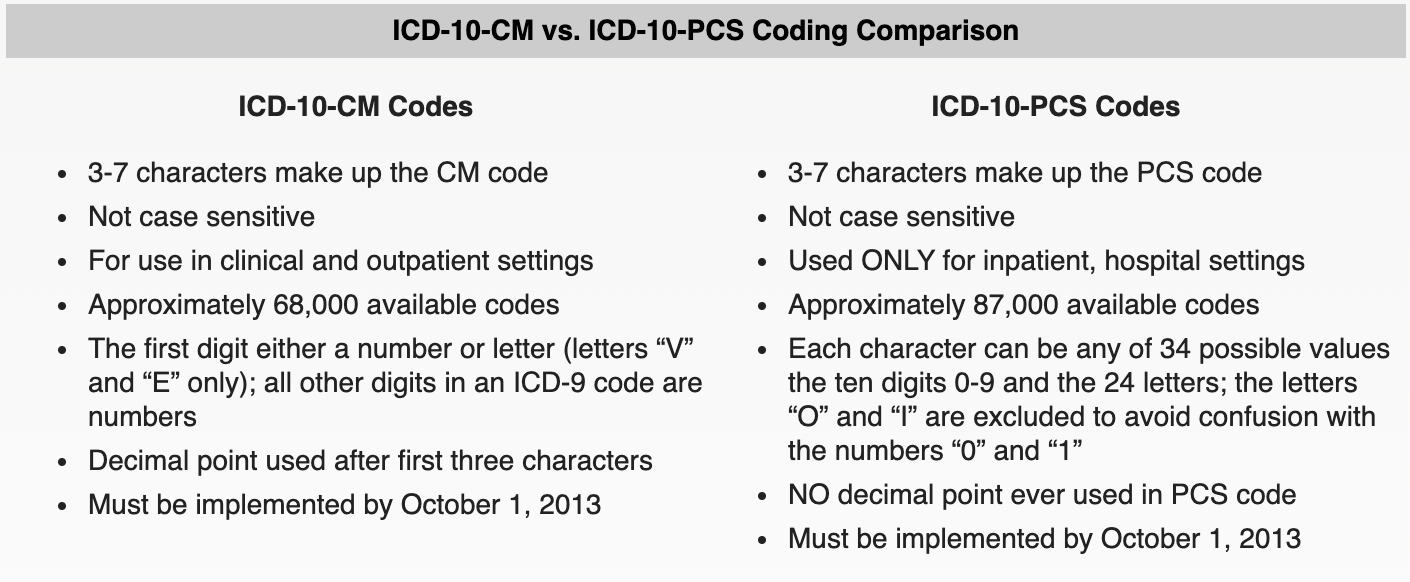

**Pretrained ICD-10 Resolver Models**

- `sbiobertresolve_icd10cm_augmented`
- `sbiobertresolve_icd10pcs`
- `sbiobertresolve_icd10cm_augmented_billable_hcc`
- `sbiobertresolve_icd10cm`
- `sbiobertresolve_icd10cm_slim_normalized`
- `sbiobertresolve_icd10cm_slim_billable_hcc`
- `sbertresolve_icd10cm_slim_billable_hcc_med`
- `sbiobertresolve_icd10cm_generalised`

### Creating ICD-10CM Pipeline

In [21]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector DL annotator, processes various sentences per line
sentenceDetectorDL = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
    .setInputCols("document") \
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = nlp.Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

# WordEmbeddingsModel pretrained "embeddings_clinical" includes a model of 1.7Gb that needs to be downloaded
word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("word_embeddings")

# Named Entity Recognition for clinical concepts.
clinical_ner = medical.NerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("ner")

ner_converter_icd = medical.NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['PROBLEM'])\
    .setPreservePosition(False)

c2doc = nlp.Chunk2Doc()\
    .setInputCols("ner_chunk")\
    .setOutputCol("doc_ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols("doc_ner_chunk")\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")


# Build up the pipeline
resolver_pipeline = nlp.Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_icd,
        c2doc,
        sbert_embedder,
        icd_resolver
  ])


empty_data = spark.createDataFrame([['']]).toDF("text")

model = resolver_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
[OK!]


**Create a SparkDataFrame with the content**

Now we will create a sample Spark dataframe with our clinical note example.

In this example we are working over a unique clinical note. In production environments a table with several of those clinical notes could be distributed in a cluster and be run in large scale systems.

In [22]:
clinical_note = (
    'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years '
    'prior to presentation and subsequent type two diabetes mellitus, associated '
    'with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, '
    'presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. '
    'Two weeks prior to presentation, she was treated with a five-day course of amoxicillin '
    'for a respiratory tract infection. She had been on dapagliflozin for six months '
    'at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; '
    'significantly, her abdominal examination was benign with no tenderness or guarding. Pertinent '
    'laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20, '
    'creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, glycated hemoglobin (HbA1c) '
    '10%, and venous pH 7.27. Serum lipase was normal at 43 U/L. Serum acetone levels could not be assessed '
    'as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for '
    'starvation ketosis, as she reported poor oral intake for three days prior to admission.')

data_ner = spark.createDataFrame([[clinical_note]]).toDF("text")

In [23]:
data_ner.show(truncate = 100)

+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior ...|
+----------------------------------------------------------------------------------------------------+



In [24]:
icd10_result = model.transform(data_ner)

In [25]:
%time icd10_result.select("icd10cm_code.metadata").show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                            metadata|
+----------------------------------------------------------------------------------------------------+
|[{chunk -> 0, all_k_results -> O24.4:::O24.41:::O24.43:::Z86.32:::Z87.5:::O24.31:::O24.11:::O24.1...|
+----------------------------------------------------------------------------------------------------+

CPU times: user 120 ms, sys: 23.5 ms, total: 143 ms
Wall time: 22.9 s


In [26]:
%%time

res_pd = get_codes_from_df(icd10_result, 'ner_chunk', 'icd10cm_code', hcc=True)
res_pd.head(10)

CPU times: user 122 ms, sys: 17.9 ms, total: 140 ms
Wall time: 20.1 s


,sent_id,ner_chunk,entity,icd10_code,all_codes,resolutions,hcc_list
0,0,gestational diabetes mellitus,PROBLEM,O24.4,"[O24.4, O24.41, O24.43, Z86.32, Z87.5, O24.31, O24.11, O24.1, O24.81]","[gestational diabetes mellitus [gestational diabetes mellitus], gestational diabetes mellitus (disorder) [gestational diabetes mellitus in pregnancy], postpartum gestational diabetes mellitus [gestational diabetes mellitus in the puerperium], history of gestational diabetes mellitus [personal history of gestational diabetes], history of gestational diabetes mellitus (situation) [personal history of complications of pregnancy, childbirth and the puerperium], pre-existing diabetes mellitus in pregnancy [unspecified pre-existing diabetes mellitus in pregnancy], pre-existing diabetes mellitus in pregnancy (disorder) [pre-existing type 2 diabetes mellitus, in pregnancy], pre-existing type 2 diabetes mellitus in pregnancy [pre-existing type 2 diabetes mellitus, in pregnancy, childbirth and the puerperium], other pre-existing diabetes mellitus in pregnancy [other pre-existing diabetes mellitus in pregnancy]]","[0||0||0, 0||0||0, 0||0||0, 1||0||0, 0||0||0, 0||0||0, 0||0||0, 0||0||0, 0||0||0]"
1,0,subsequent type two diabetes mellitus,PROBLEM,O24.11,"[O24.11, E11.8, E11, E13.9, E11.9, E11.3, E11.44, Z86.3, Z86.39, E11.32, E11.43, E11.5]","[pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy], disorder associated with type 2 diabetes mellitus [type 2 diabetes mellitus with unspecified complications], type 2 diabetes mellitus [type 2 diabetes mellitus], secondary diabetes mellitus [other specified diabetes mellitus without complications], diabetes mellitus type 2 [type 2 diabetes mellitus without complications], disorder of eye due to type 2 diabetes mellitus [type 2 diabetes mellitus with ophthalmic complications], disorder of nervous system due to type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic amyotrophy], history of diabetes mellitus type 2 (situation) [personal history of endocrine, nutritional and metabolic diseases], history of diabetes mellitus type 2 [personal history of other endocrine, nutritional and metabolic disease], secondary endocrine diabetes mellitus [type 2 diabetes mellitus with mild nonproliferative diabetic retinopathy], neurological disorder with type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic autonomic (poly)neuropathy], peripheral circulatory disorder due to type 2 diabetes mellitus [type 2 diabetes mellitus with circulatory complications]]","[0||0||0, 1||1||18, 0||0||0, 1||1||19, 1||1||19, 0||0||0, 1||1||18, 0||0||0, 1||0||0, 0||0||0, 1||1||18, 0||0||0]"
2,0,an acute hepatitis,PROBLEM,B15,"[B15, K72.0, B17.9, B17.2, Z03.89, B15.9, K75.2, K71.2, B19.9, B16, K70.1, B16.9]","[acute hepatitis a [acute hepatitis a], acute hepatitis [acute and subacute hepatic failure], acute infectious hepatitis [acute viral hepatitis, unspecified], acute hepatitis e [acute hepatitis e], acute infectious hepatitis suspected [encounter for observation for other suspected diseases and conditions ruled out], acute type a viral hepatitis [hepatitis a without hepatic coma], acute focal hepatitis [nonspecific reactive hepatitis], toxic liver disease with acute hepatitis [toxic liver disease with acute hepatitis], fulminant hepatitis [unspecified viral hepatitis without hepatic coma], acute hepatitis b [acute hepatitis b], acute alcoholic hepatitis [alcoholic hepatitis], acute fulminating viral hepatitis [acute hepatitis b without delta-agent and without hepatic coma]]","[0||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0, 0||0||0, 1||0||0]"
3,0,obesity,PROBLEM,E66.9,"[E66.9, E66.8, Z68.41, Q13.0, E66, E66.01, Z86.39, E34.9, H35.50, Z83.49, Q55.62, E66.3]","[obesity [obesity, unspecified], abdominal obesity [other obesity], obese [body mass index [bmi] 40.0-44.9, adult], central obesity [coloboma of iris], overweight and obesity [overweight and 

In [27]:
res_pd["billable"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]
res_pd["hcc_status"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
res_pd["hcc_code"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

res_pd.drop("hcc_list", axis=1, inplace= True)

In [28]:
res_pd.head(15)

,sent_id,ner_chunk,entity,icd10_code,all_codes,resolutions,billable,hcc_status,hcc_code
0,0,gestational diabetes mellitus,PROBLEM,O24.4,"[O24.4, O24.41, O24.43, Z86.32, Z87.5, O24.31, O24.11, O24.1, O24.81]","[gestational diabetes mellitus [gestational diabetes mellitus], gestational diabetes mellitus (disorder) [gestational diabetes mellitus in pregnancy], postpartum gestational diabetes mellitus [gestational diabetes mellitus in the puerperium], history of gestational diabetes mellitus [personal history of gestational diabetes], history of gestational diabetes mellitus (situation) [personal history of complications of pregnancy, childbirth and the puerperium], pre-existing diabetes mellitus in pregnancy [unspecified pre-existing diabetes mellitus in pregnancy], pre-existing diabetes mellitus in pregnancy (disorder) [pre-existing type 2 diabetes mellitus, in pregnancy], pre-existing type 2 diabetes mellitus in pregnancy [pre-existing type 2 diabetes mellitus, in pregnancy, childbirth and the puerperium], other pre-existing diabetes mellitus in pregnancy [other pre-existing diabetes mellitus in pregnancy]]","[0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,0,subsequent type two diabetes mellitus,PROBLEM,O24.11,"[O24.11, E11.8, E11, E13.9, E11.9, E11.3, E11.44, Z86.3, Z86.39, E11.32, E11.43, E11.5]","[pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy], disorder associated with type 2 diabetes mellitus [type 2 diabetes mellitus with unspecified complications], type 2 diabetes mellitus [type 2 diabetes mellitus], secondary diabetes mellitus [other specified diabetes mellitus without complications], diabetes mellitus type 2 [type 2 diabetes mellitus without complications], disorder of eye due to type 2 diabetes mellitus [type 2 diabetes mellitus with ophthalmic complications], disorder of nervous system due to type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic amyotrophy], history of diabetes mellitus type 2 (situation) [personal history of endocrine, nutritional and metabolic diseases], history of diabetes mellitus type 2 [personal history of other endocrine, nutritional and metabolic disease], secondary endocrine diabetes mellitus [type 2 diabetes mellitus with mild nonproliferative diabetic retinopathy], neurological disorder with type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic autonomic (poly)neuropathy], peripheral circulatory disorder due to type 2 diabetes mellitus [type 2 diabetes mellitus with circulatory complications]]","[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]","[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]","[0, 18, 0, 19, 19, 0, 18, 0, 0, 0, 18, 0]"
2,0,an acute hepatitis,PROBLEM,B15,"[B15, K72.0, B17.9, B17.2, Z03.89, B15.9, K75.2, K71.2, B19.9, B16, K70.1, B16.9]","[acute hepatitis a [acute hepatitis a], acute hepatitis [acute and subacute hepatic failure], acute infectious hepatitis [acute viral hepatitis, unspecified], acute hepatitis e [acute hepatitis e], acute infectious hepatitis suspected [encounter for observation for other suspected diseases and conditions ruled out], acute type a viral hepatitis [hepatitis a without hepatic coma], acute focal hepatitis [nonspecific reactive hepatitis], toxic liver disease with acute hepatitis [toxic liver disease with acute hepatitis], fulminant hepatitis [unspecified viral hepatitis without hepatic coma], acute hepatitis b [acute hepatitis b], acute alcoholic hepatitis [alcoholic hepatitis], acute fulminating viral hepatitis [acute hepatitis b without delta-agent and without hepatic coma]]","[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,0,obesity,PROBLEM,E66.9,"[E66.9, E66.8, Z68.41, Q13.0, E66, E66.01, Z86.39, E34.9, H35.50, Z83.49, Q55.62, E66.3]","[obesity [obesity, unspecified], abdominal obesity [other obesity], obese [body mass index [bmi] 40.0-44.9, adult], central obesity [coloboma of iris], o

Lets apply some HTML formating by using `sparknlp_display` library to see the results of the pipeline in a nicer layout:

In [29]:
from sparknlp_display import EntityResolverVisualizer

icd10_lp = nlp.LightPipeline(model)

light_result = icd10_lp.fullAnnotate(clinical_note)

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code')

### ICD10CM with BertSentenceChunkEmbeddings

**BertSentenceChunkEmbeddings**

- This annotator let users to aggregate sentence embeddings and ner chunk embeddings to get more specific and accurate resolution codes. It works by averaging context and chunk embeddings to get contextual information. Input to this annotator is the context (sentence) and ner chunks, while the output is embedding for each chunk that can be fed to the resolver model. The `setChunkWeight` parameter can be used to control the influence of surrounding context.

- For more information and examples of `BertSentenceChunkEmbeddings` annotator, you can check here:
[24.1.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/24.1.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb)

Lets do the same process by using `BertSentenceEmbeddings` annotator and compare the results. We will create a new pipeline by using this annotator with SentenceEntityResolverModel.

In [30]:
#Get average sentence-chunk Bert embeddings
sentence_chunk_embeddings = medical.BertSentenceChunkEmbeddings.pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["sentence", "ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)\
    .setChunkWeight(0.5) #default : 0.5

icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver_pipeline_SCE = nlp.Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_icd,
        sentence_chunk_embeddings,
        icd_resolver
  ])


empty_data = spark.createDataFrame([['']]).toDF("text")
model_SCE = resolver_pipeline_SCE.fit(empty_data)

sbiobert_base_cased_mli download started this may take some time.
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
[OK!]


In [31]:
model.stages

[DocumentAssembler_7a17170650d9,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_6b043f795eaa,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 NER_CONVERTER_e54792dfa123,
 Chunk2Doc_2a82eddfbe65,
 BERT_SENTENCE_EMBEDDINGS_0bee53f1b2cc,
 ENTITY_05f90ef679b8]

In [32]:
model_SCE.stages

[DocumentAssembler_7a17170650d9,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_5e0a725816fd,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 NER_CONVERTER_5af55a7ecc14,
 BERTSENTENCECHUNKEMBEDDINGS_b3d919da597e,
 ENTITY_05f90ef679b8]

In [33]:
icd10_result_SCE = model_SCE.transform(data_ner)

In [34]:
%%time

res_SCE_pd = get_codes_from_df(icd10_result_SCE, 'ner_chunk', 'icd10cm_code', hcc=True)

res_SCE_pd["billable"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]
res_SCE_pd["hcc_status"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
res_SCE_pd["hcc_code"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

res_SCE_pd.drop("hcc_list", axis=1, inplace= True)

CPU times: user 142 ms, sys: 21.5 ms, total: 164 ms
Wall time: 20.8 s


In [35]:
res_SCE_pd.head(15)

,sent_id,ner_chunk,entity,icd10_code,all_codes,resolutions,billable,hcc_status,hcc_code
0,0,gestational diabetes mellitus,PROBLEM,O24.4,"[O24.4, O24.43, O24.41, O24.434, O24.42, O24.414, O24.13]","[gestational diabetes mellitus, class d [gestational diabetes mellitus], gestational diabetes mellitus in the puerperium [gestational diabetes mellitus in the puerperium], maternal gestational diabetes mellitus [gestational diabetes mellitus in pregnancy], gestational diabetes mellitus in the puerperium, insulin controlled [gestational diabetes mellitus in the puerperium, insulin controlled], gestational diabetes mellitus in childbirth [gestational diabetes mellitus in childbirth], gestational diabetes mellitus in pregnancy, insulin controlled [gestational diabetes mellitus in pregnancy, insulin controlled], pre-existing type 2 diabetes mellitus, in the puerperium [pre-existing type 2 diabetes mellitus, in the puerperium]]","[0, 0, 0, 1, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
1,0,subsequent type two diabetes mellitus,PROBLEM,O24.13,"[O24.13, E11.6, E11.43, O24.11, E11.10, E11.0, O24.12, E11.4, E11.69, E11.1, O24.1, K31.8, E11.33, O24.4, E11.2]","[pre-existing type 2 diabetes mellitus, in the puerperium [pre-existing type 2 diabetes mellitus, in the puerperium], gastroparesis co-occurrent and due to type 2 diabetes mellitus [type 2 diabetes mellitus with other specified complications], gastroparesis with type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic autonomic (poly)neuropathy], pregnancy and type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy], ketoacidosis due to type 2 diabetes mellitus [type 2 diabetes mellitus with ketoacidosis without coma], hyperosmolar coma due to type 2 diabetes mellitus [type 2 diabetes mellitus with hyperosmolarity], pre-existing type 2 diabetes mellitus, in childbirth [pre-existing type 2 diabetes mellitus, in childbirth], cranial nerve palsy co-occurrent and due to type 2 diabetes mellitus [type 2 diabetes mellitus with neurological complications], angina due to type 2 diabetes mellitus [type 2 diabetes mellitus with other specified complication], ketoacidosis due to type 2 diabetes mellitus (disorder) [type 2 diabetes mellitus with ketoacidosis], pre-existing type 2 diabetes mellitus in pregnancy [pre-existing type 2 diabetes mellitus, in pregnancy, childbirth and the puerperium], diabetic gastroparesis associated with type 2 diabetes mellitus [other specified diseases of stomach and duodenum], moderate nonproliferative retinopathy co-occurrent and due to type 2 diabetes mellitus [type 2 diabetes mellitus with moderate nonproliferative diabetic retinopathy], gestational diabetes mellitus, class a>2< [gestational diabetes mellitus], persistent microalbuminuria due to type 2 diabetes mellitus [type 2 diabetes mellitus with kidney complications]]","[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 18, 0, 17, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0]"
2,0,an acute hepatitis,PROBLEM,B16.9,"[B16.9, B15.9, B16.2, B17.9, B16.0, E80.21, K71.2, O26.6, B18.1, F10.98, B15.0]","[acute fulminating type b viral hepatitis (disorder) [acute hepatitis b without delta-agent and without hepatic coma], acute fulminating type a viral hepatitis (disorder) [hepatitis a without hepatic coma], hepatic coma due to acute hepatitis b [acute hepatitis b without delta-agent with hepatic coma], acute fulminating viral hepatitis (disorder) [acute viral hepatitis, unspecified], acute viral hepatitis b with hepatic coma [acute hepatitis b with delta-agent with hepatic coma], acute intermittent (hepatic) porphyria [acute intermittent (hepatic) porphyria], toxic liver disease with acute hepatitis (disorder) [toxic liver disease with acute hepatitis], acute fatty liver of pregnancy [liver and biliary tract disorders in pregnancy, childbirth and the puerperium], chronic viral hepatitis b with hepatic coma [chronic viral hepatitis b without

Lets show the results on the raw text.

In [37]:
icd10_SCE_lp = nlp.LightPipeline(model_SCE)

light_result = icd10_SCE_lp.fullAnnotate(clinical_note)

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code')

Lets compare the results that we got from these two methods.

In [38]:
sentence_df = icd10_result.select(F.explode(F.arrays_zip(icd10_result.sentence.metadata,
                                                         icd10_result.sentence.result)).alias("cols")) \
                          .select(F.expr("cols['0']['sentence']").alias("sent_id"),
                                  F.expr("cols['1']").alias("sentence_all")).toPandas()

comparison_df = pd.merge(res_pd.loc[:,'sent_id':'resolutions'],res_SCE_pd.loc[:,'sent_id':'resolutions'], on=['sent_id',"ner_chunk", "entity"], how='inner')
comparison_df.columns=['sent_id','ner_chunk', 'entity', 'icd10_code', 'all_codes', 'resolutions', 'icd10_code_SCE', 'all_codes_SCE', 'resolutions_SCE']

comparison_df = pd.merge(sentence_df, comparison_df,on="sent_id").drop('sent_id', axis=1)
comparison_df.head(15)

,sentence_all,ner_chunk,entity,icd10_code,all_codes,resolutions,icd10_code_SCE,all_codes_SCE,resolutions_SCE
0,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.",gestational diabetes mellitus,PROBLEM,O24.4,"[O24.4, O24.41, O24.43, Z86.32, Z87.5, O24.31, O24.11, O24.1, O24.81]","[gestational diabetes mellitus [gestational diabetes mellitus], gestational diabetes mellitus (disorder) [gestational diabetes mellitus in pregnancy], postpartum gestational diabetes mellitus [gestational diabetes mellitus in the puerperium], history of gestational diabetes mellitus [personal history of gestational diabetes], history of gestational diabetes mellitus (situation) [personal history of complications of pregnancy, childbirth and the puerperium], pre-existing diabetes mellitus in pregnancy [unspecified pre-existing diabetes mellitus in pregnancy], pre-existing diabetes mellitus in pregnancy (disorder) [pre-existing type 2 diabetes mellitus, in pregnancy], pre-existing type 2 diabetes mellitus in pregnancy [pre-existing type 2 diabetes mellitus, in pregnancy, childbirth and the puerperium], other pre-existing diabetes mellitus in pregnancy [other pre-existing diabetes mellitus in pregnancy]]",O24.4,"[O24.4, O24.43, O24.41, O24.434, O24.42, O24.414, O24.13]","[gestational diabetes mellitus, class d [gestational diabetes mellitus], gestational diabetes mellitus in the puerperium [gestational diabetes mellitus in the puerperium], maternal gestational diabetes mellitus [gestational diabetes mellitus in pregnancy], gestational diabetes mellitus in the puerperium, insulin controlled [gestational diabetes mellitus in the puerperium, insulin controlled], gestational diabetes mellitus in childbirth [gestational diabetes mellitus in childbirth], gestational diabetes mellitus in pregnancy, insulin controlled [gestational diabetes mellitus in pregnancy, insulin controlled], pre-existing type 2 diabetes mellitus, in the puerperium [pre-existing type 2 diabetes mellitus, in the puerperium]]"
1,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.",subsequent type two diabetes mellitus,PROBLEM,O24.11,"[O24.11, E11.8, E11, E13.9, E11.9, E11.3, E11.44, Z86.3, Z86.39, E11.32, E11.43, E11.5]","[pre-existing type 2 diabetes mellitus [pre-existing type 2 diabetes mellitus, in pregnancy], disorder associated with type 2 diabetes mellitus [type 2 diabetes mellitus with unspecified complications], type 2 diabetes mellitus [type 2 diabetes mellitus], secondary diabetes mellitus [other specified diabetes mellitus without complications], diabetes mellitus type 2 [type 2 diabetes mellitus without complications], disorder of eye due to type 2 diabetes mellitus [type 2 diabetes mellitus with ophthalmic complications], disorder of nervous system due to type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic amyotrophy], history of diabetes mellitus type 2 (situation) [personal history of endocrine, nutritional and metabolic diseases], history of diabetes mellitus type 2 [personal history of other endocrine, nutritional and metabolic disease], secondary endocrine diabetes mellitus [type 2 diabetes mellitus with mild nonproliferative diabetic retinopathy], neurological disorder with type 2 diabetes mellitus [type 2 diabetes mellitus with diabetic autonomic (poly)neuropathy], peripheral circulatory disorder due to type 2 diabetes mellitus [type 2 diabetes mellitus with circulatory complications]]",O24.13,"[O2

## Sentence Entity Resolver (CPT)

The Current Procedural Terminology (CPT) code set is a medical code set maintained by the American Medical Association. The CPT code set describes medical, surgical, and diagnostic services and is designed to communicate uniform information about medical services and procedures among physicians, coders, patients, accreditation organizations, and payers for administrative, financial, and analytical purposes.

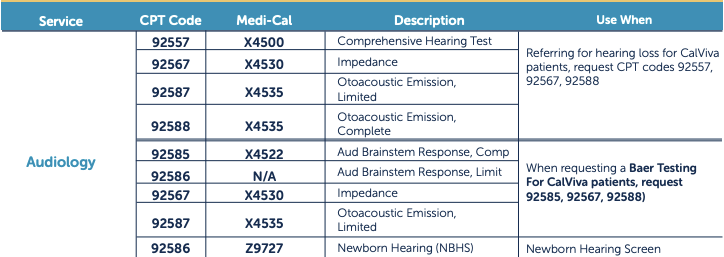

**Pretrained Models**

- `sbiobertresolve_cpt`
- `sbiobertresolve_cpt_procedures_augmented`
- `sbiobertresolve_cpt_augmented`
- `sbiobertresolve_cpt_procedures_measurements_augmented`

**We will create a pipeline to detect bodyparts and imaging tests entities and their relations. Then we will use these related chunks in CPT resolver model to get their CPT code.**

In [40]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetectorDL = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("word_embeddings")


pos_tagger = nlp.PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

dependency_parser = nlp.DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

# Named Entity Recognition for radiology reports.
clinical_ner = medical.NerModel.pretrained("jsl_rd_ner_wip_greedy_clinical", "en", "clinical/models") \
   .setInputCols(["sentence", "token", "word_embeddings"]) \
   .setOutputCol("ner")

ner_chunker = medical.NerConverter()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

re_model = medical.RelationExtractionModel()\
    .pretrained("re_bodypart_directions", "en", 'clinical/models')\
    .setInputCols(["word_embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["imagingtest-bodypart", "bodypart-imagingtest"])\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.5)


# Build up the pipeline
relation_pipeline = nlp.Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        pos_tagger,
        dependency_parser,
        clinical_ner,
        ner_chunker,
        re_model
        ])


empty_data = spark.createDataFrame([['']]).toDF("text")

rel_model = relation_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
jsl_rd_ner_wip_greedy_clinical download started this may take some time.
[OK!]
re_bodypart_directions download started this may take some time.
[OK!]


In [41]:
light_rel_model = nlp.LightPipeline(rel_model)

In [42]:
text="Left shin pain. I have ordered x-ray of the left fibula and knee today. The patient will return to the clinic in 3 weeks. He is to call me in the interim for any problems."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

,entity1,chunk1,entity2,chunk2,confidence
0,ImagingTest,x-ray,BodyPart,fibula,1.0
1,ImagingTest,x-ray,BodyPart,knee,0.9458425


**Now we can use get CPT codes of these related chunks.**

In [43]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

cpt_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_cpt_procedures_measurements_augmented","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("cpt_code")\
    .setDistanceFunction("EUCLIDEAN")


cpt_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        cpt_resolver])


cpt_lp = nlp.LightPipeline(cpt_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_cpt_procedures_measurements_augmented download started this may take some time.
[OK!]


In [44]:
text = 'fibula x-ray'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 23.5 ms, sys: 3.94 ms, total: 27.5 ms
Wall time: 391 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,fibula x-ray,0,11,73590,"[73590, 27676, 73550, 27707, 73090, 01390, 01392, 27635, 27485, 27709, 20955, 71100, 73140]","[Tibia and fibula X-ray [Radiologic examination; tibia and fibula, 2 views], Incision of fibula [Repair, dislocating peroneal tendons; with fibular osteotomy], Femur X-ray (procedure) [Radiologic examination, femur, 2 views], Osteotomy; fibula [Osteotomy; fibula], Forearm X-ray [Radiologic examination; forearm, 2 views], Anesthesia for closed procedure on upper end of fibula [Anesthesia for all closed procedures on upper ends of tibia, fibula, and/or patella], Anesthesia for open procedure on upper end of fibula [Anesthesia for all open procedures on upper ends of tibia, fibula, and/or patella], Excision of lesion of fibula (procedure) [Excision or curettage of bone cyst or benign tumor, tibia or fibula], Hemiepiphyseal arrest of proximal fibula for genu varus [Arrest, hemiepiphyseal, distal femur or proximal tibia or fibula (eg, genu varus or valgus)], Division of tibia and fibula [Osteotomy; tibia and fibula], Grafting of fibula (procedure) [Bone graft with microvascular anastomosis; fibula], X-ray of ribs of one side of body, 2 views [Radiologic examination, ribs, unilateral; 2 views], Fingers X-ray [Radiologic examination, finger(s), minimum of 2 views]]","[0.0895, 0.0970, 0.1360, 0.1430, 0.1364, 0.1417, 0.1440, 0.1474, 0.1545, 0.1595, 0.1589, 0.1682, 0.1735]"


In [45]:
text = 'knee x-ray'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 25 ms, sys: 9.69 ms, total: 34.7 ms
Wall time: 394 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,knee x-ray,0,9,73564,"[73564, 73580, 73560, 73565, 73592, 27486, 01432, 1010487, 27435, 29870, 27540, 27570]","[Knee X-ray [Radiologic examination, knee; complete, 4 or more views], Knee arthrogram [Radiologic examination, knee, arthrography, radiological supervision and interpretation], X-ray of knee, lateral and sunrise views [Radiologic examination, knee; 1 or 2 views], X-ray of both knees, standing, front to back view [Radiologic examination, knee; both knees, standing, anteroposterior], X-ray of leg in infant minimum of 2 views [Radiologic examination; lower extremity, infant, minimum of 2 views], Knee joint operations [Revision of total knee arthroplasty, with or without allograft; 1 component], Anesthesia for arteriovenous fistula of knee area [Anesthesia for procedures on veins of knee and popliteal area; arteriovenous fistula], Radiologic examination, knee [Radiologic examination, knee], Incision of back portion of knee joint capsule [Capsulotomy, posterior capsular release, knee], Diagnostic examination of knee using an endoscope [Arthroscopy, knee, diagnostic, with or without synovial biopsy (separate procedure)], Operative procedure on knee [Open treatment of intercondylar spine(s) and/or tuberosity fracture(s) of the knee, includes internal fixation, when performed], Alignment of knee joint under anesthesia [Manipulation of knee joint under general anesthesia (includes application of traction or other fixation devices)]]","[0.0000, 0.0907, 0.0916, 0.1101, 0.1097, 0.1096, 0.1118, 0.1171, 0.1222, 0.1391, 0.1309, 0.1334]"


In [46]:
text="TECHNIQUE IN DETAIL: After informed consent was obtained from the patient and his mother, the chest was scanned with portable ultrasound."

light_result = light_rel_model.fullAnnotate(text)
get_relations_df(light_result)

,entity1,chunk1,entity2,chunk2,confidence
0,BodyPart,chest,ImagingTest,portable ultrasound,0.9999802


In [47]:
text = 'chest portable ultrasound'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 23.8 ms, sys: 8.18 ms, total: 32 ms
Wall time: 388 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,chest portable ultrasound,0,24,1010771,"[1010771, 76604, 76510, 45391, 31654, 97035, 76999, 59072, 76800, 93307, 76536, 36465, 1010759, 76981]","[Diagnostic Ultrasound Procedures of the Chest [Diagnostic Ultrasound Procedures of the Chest], Ultrasound of chest [Ultrasound, chest (includes mediastinum), real time with image documentation], A scan ultrasound [Ophthalmic ultrasound, diagnostic; B-scan and quantitative A-scan performed during the same patient encounter], USS - Ultrasound scan [Colonoscopy, flexible; with endoscopic ultrasound examination limited to the rectum, sigmoid, descending, transverse, or ascending colon and cecum, and adjacent structures], Examination of lung airways using an endoscope with imaging guidance and ultrasound [Bronchoscopy, rigid or flexible, including fluoroscopic guidance, when performed; with transendoscopic endobronchial ultrasound (EBUS) during bronchoscopic diagnostic or therapeutic intervention(s) for peripheral lesion(s) (List separately in addition...], APPL MODALITY 1/> AREAS ULTRASOUND EA 15 MIN [Application of a modality to 1 or more areas; ultrasound, each 15 minutes], Ultrasound procedure [Unlisted ultrasound procedure (eg, diagnostic, interventional)], US - Ultrasound scan guidance [Fetal umbilical cord occlusion, including ultrasound guidance], Ultrasound, spinal canal and contents [Ultrasound, spinal canal and contents], Chest ultrasound examination of heart [Echocardiography, transthoracic, real-time with image documentation (2D), includes M-mode recording, when performed, complete, without spectral or color Doppler echocardiography], Diagnostic ultrasound of head and neck [Ultrasound, soft tissues of head and neck (eg, thyroid, parathyroid, parotid), real time with image documentation], Injection of chemical agent into single incompetent vein of leg using ultrasound guidance [Injection of non-compounded foam sclerosant with ultrasound compression maneuvers to guide dispersion of the injectate, inclusive of all imaging guidance and monitoring; single incompetent extremity truncal vein (eg, great saphenous vein, accessory sap...], Diagnostic Ultrasound Procedures [Diagnostic Ultrasound Procedures], Ultrasound elastography of parenchymal tissue [Ultrasound, elastography; parenchyma (eg, organ)]]","[0.1058, 0.1137, 0.1571, 0.1582, 0.1670, 0.1671, 0.1649, 0.1722, 0.1749, 0.1786, 0.1782, 0.1856, 0.1839, 0.1940]"


In [48]:
text="MRI scan identified a soft tissue injury in the patient's leg, guiding the appropriate treatment plan."

light_result = light_rel_model.fullAnnotate(text)
get_relations_df(light_result)

,entity1,chunk1,entity2,chunk2,confidence
0,ImagingTest,MRI scan,BodyPart,leg,0.99996376


In [49]:
text = 'leg MRI scan'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 20.2 ms, sys: 4.94 ms, total: 25.1 ms
Wall time: 385 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,leg MRI scan,0,11,73718,"[73718, 73721, 73719, 73725, 73722, 76498, 73720, 73700, 73218, 88142, 3324F, 35703, 73723, 73592, 27607, 29705, 35860, 88175, 72270, 95851, 71550, 36465, 27734, 73221]","[MRI scan of leg [Magnetic resonance (eg, proton) imaging, lower extremity other than joint; without contrast material(s)], MRI scan of leg joint [Magnetic resonance (eg, proton) imaging, any joint of lower extremity; without contrast material], MRI scan of leg with contrast [Magnetic resonance (eg, proton) imaging, lower extremity other than joint; with contrast material(s)], MRA scan of leg blood vessels [Magnetic resonance angiography, lower extremity, with or without contrast material(s)], MRI scan of leg joint with contrast [Magnetic resonance (eg, proton) imaging, any joint of lower extremity; with contrast material(s)], MRI scan [Unlisted magnetic resonance procedure (eg, diagnostic, interventional)], MRI scan of leg before and after contrast [Magnetic resonance (eg, proton) imaging, lower extremity other than joint; without contrast material(s), followed by contrast material(s) and further sequences], CT scan leg [Computed tomography, lower extremity; without contrast material], MRI scan of arm [Magnetic resonance (eg, proton) imaging, upper extremity, other than joint; without contrast material(s)], CYTP CERV/VAG AUTO THIN LAYER PREP MNL SCREEN [Cytopathology, cervical or vaginal (any reporting system), collected in preservative fluid, automated thin layer preparation; manual screening under physician supervision], MRI CT SCAN ORDERED REVIEWED/REQUESTED [MRI or CT scan ordered, reviewed or requested (EPI)], Exploration of artery of leg [Exploration not followed by surgical repair, artery; lower extremity (eg, common femoral, deep femoral, superficial femoral, popliteal, tibial, peroneal)], MRI scan of leg joint before and after contrast [Magnetic resonance (eg, proton) imaging, any joint of lower extremity; without contrast material(s), followed by contrast material(s) and further sequences], X-ray of leg in infant minimum of 2 views [Radiologic examination; lower extremity, infant, minimum of 2 views], Incision of leg [Incision (eg, osteomyelitis or bone abscess), leg or ankle], Removal or bivalving; full arm or full leg cast [Removal or bivalving; full arm or full leg cast], Exploration of arm or leg for postsurgical bleeding, blood clot, or infection [Exploration for postoperative hemorrhage, thrombosis or infection; extremity], CYTP C/V AUTO THIN LYR PREPJ SCR MNL RESCR PHYS [Cytopathology, cervical or vaginal (any reporting system), collected in preservative fluid, automated thin layer preparation; with screening by automated system and manual rescreening or review, under physician supervision], Myelography [Myelography, 2 or more regions (eg, lumbar/thoracic, cervical/thoracic, lumbar/cervical, lumbar/thoracic/cervical), radiological supervision and interpretation], Range of motion testing of arm, leg or each spine section [Range of motion measurements and report (separate procedure); each extremity (excluding hand) or each trunk section (spine)], MRI scan of chest [Magnetic resonance (eg, proton) imaging, chest (eg, for evaluation of hilar and mediastinal lymphadenopathy); without contrast material(s)], Injection of chemical agent into single incompetent vein of leg using ultrasound guidance [Injection of non-compounded foam sclerosant with ultrasound compression maneuvers to guide dispersion of the injectate, inclusive of all imaging guidance and monitoring; single incompetent extremity truncal vein (eg, great saphenous vein, accessory sap...], Scraping or stapling of growth plates of leg bones, open procedure [Arrest, epiphyseal (epiphysiodesis), open; distal tibia and fibula], MRI scan of arm joint [Magnetic resonance (eg, proton) imaging, any joint of upper extremity; without contrast material(s)]]","[0.0374, 0.0952, 0.1163, 0.1483, 0.1503, 0.1576, 0.1809

## Sentence Entity Resolver (SNOMED)

SNOMED CT is one of a suite of designated standards for use in U.S. Federal Government systems for the electronic exchange of clinical health information and is also a required standard in interoperability specifications of the U.S. Healthcare Information Technology Standards Panel. The clinical terminology is owned and maintained by SNOMED International, a not-for-profit association.

SNOMED CT:

- Is the most comprehensive and precise, multilingual health terminology in the world.
- Has been, and continues to be, developed collaboratively to ensure it meets the diverse needs and expectations of the worldwide medical profession.
- Assists with the electronic exchange of clinical health information.
- Can be mapped to other coding systems, such as ICD-9 and ICD-10, which helps facilitate semantic interoperability.
- Is accepted as a common global language for health terms in over 50 countries.
- Is a resource with extensive, scientifically validated clinical content

**Pretrained SNOMED Resolver Models**

- `sbiobertresolve_snomed_auxConcepts_int`
- `sbiobertresolve_snomed_findings`
- `sbiobertresolve_snomed_findings_int`
- `sbiobertresolve_snomed_auxConcepts`
- `sbiobertresolve_snomed_procedures_measurements`
- `sbertresolve_snomed_bodyStructure_med`
- `sbiobertresolve_snomed_bodyStructure`
- `sbiobertresolve_snomed_findings_aux_concepts`
- `sbertresolve_snomed_conditions`
- `sbiobertresolve_snomed_drug`

In [51]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

snomed_ct_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_snomed_findings","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("snomed_code")\
    .setDistanceFunction("EUCLIDEAN")

snomed_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        snomed_ct_resolver])

snomed_lp = nlp.LightPipeline(snomed_pipelineModel)


sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_snomed_findings download started this may take some time.
[OK!]


In [52]:
text = 'brain tumor'

%time get_codes (snomed_lp, text, vocab='snomed_code')

CPU times: user 27.2 ms, sys: 2.37 ms, total: 29.5 ms
Wall time: 541 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,brain tumor,0,10,254935002,"[254935002, 254936001, 448989001, 254938000, 724807008, 254945000, 126952004, 93727008, 277369003, 444545003, 1156461003, 762457009, 94225005, 93726004, 92030004, 126961004, 254941009, 1157141006]","[brain tumor, glial tumor of brain, carcinoma of brain, astrocytic tumor of brain, glioma of central nervous system, embryonal tumor of brain, neoplasm of brain, malignant neoplasm of brain, hamartoma of brain, glioma of brainstem, gliosarcoma of brain, astroblastoma of brain, secondary cancer of brain, malignant neoplasm of brain stem, benign brain tumor, neoplasm of brain stem, mixed glial tumor of brain, astroblastoma of central nervous system]","[0.0000, 0.0719, 0.0892, 0.0992, 0.1018, 0.1023, 0.1026, 0.1046, 0.1061, 0.1106, 0.1102, 0.1107, 0.1117, 0.1125, 0.1128, 0.1148, 0.1168, 0.1192]"


In [53]:
text = 'chest pain on left side'

%time get_codes (snomed_lp, text, vocab='snomed_code')

CPU times: user 20.6 ms, sys: 7.57 ms, total: 28.2 ms
Wall time: 532 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,chest pain on left side,0,22,285385002,"[285385002, 427293006, 15743561000119103, 287047008, 316801000119101, 287045000, 425677008, 316841000119104, 316761000119109, 1260145003, 162049009, 426469008, 426483005, 425473004, 316771000119103, 339211000119104, 774135008, 285387005, 1076731000119106, 1119218004, 15916971000119109, 316821000119105]","[left sided chest pain, pain radiating to left side of chest, chronic pain of left upper limb, pain in left leg, pain of left lower leg, pain in left upper limb, pain radiating to left arm, pain of left upper arm, pain of left forearm, pain of left shoulder region, left flank pain, pain radiating to left leg, pain radiating to thoracic region left side, pain radiating to left shoulder, pain of left hand, pain of left eye, pain of left shoulder blade, left sided abdominal pain, joint pain in left hand, pain in left abdominal lumbar region, pain of left shoulder joint, pain of left thigh]","[0.0212, 0.0261, 0.0475, 0.0480, 0.0481, 0.0485, 0.0488, 0.0489, 0.0525, 0.0541, 0.0547, 0.0553, 0.0577, 0.0578, 0.0580, 0.0586, 0.0593, 0.0597, 0.0596, 0.0602, 0.0619, 0.0648]"


## Sentence Entity Resolver (LOINC)

- Logical Observation Identifiers Names and Codes (LOINC) is a database and universal standard for identifying medical laboratory observations. First developed in 1994, it was created and is maintained by the Regenstrief Institute, a US nonprofit medical research organization. LOINC was created in response to the demand for an electronic database for clinical care and management and is publicly available at no cost.

- It is endorsed by the American Clinical Laboratory Association. Since its inception, the database has expanded to include not just medical laboratory code names but also nursing diagnosis, nursing interventions, outcomes classification, and patient care data sets.

- LOINC applies universal code names and identifiers to medical terminology related to electronic health records. The purpose is to assist in the electronic exchange and gathering of clinical results (such as laboratory tests, clinical observations, outcomes management and research). LOINC has two main parts: laboratory LOINC and clinical LOINC.

**Pretrained LOINC Resovler Models**

- `sbiobertresolve_loinc`
- `sbiobertresolve_loinc_cased`
- `sbiobertresolve_loinc_augmented`
- `sbluebertresolve_loinc`
- `sbluebertresolve_loinc_uncased`
- `sbiobertresolve_loinc_numeric `




In [54]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

loinc_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_loinc_augmented", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("loinc_code")\
    .setDistanceFunction("EUCLIDEAN")

loinc_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        loinc_resolver])

loinc_lp = nlp.LightPipeline(loinc_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_loinc_augmented download started this may take some time.
[OK!]


In [55]:
text = 'FLT3 gene mutation analysis'

%time get_codes (loinc_lp, text, vocab='loinc_code')

CPU times: user 31.8 ms, sys: 6.76 ms, total: 38.5 ms
Wall time: 770 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,FLT3 gene mutation analysis,0,26,47958-4,"[47958-4, LP310331-6, 21676-2, 53863-7, 92843-2, 57963-1, 96968-3, 49873-3, 58987-9, 53840-5, 99129-9, 81816-1, 72520-0, 22074-9, 21740-6, 34499-4, 49704-0, 46225-9, 38532-8, 71358-6, 81831-0, 53895-9, 35298-9, 49872-5, 48972-4]","[FLT3 gene targeted mutation analysis [FLT3 gene targeted mutation analysis], FLT3 gene p.Asp835 mutations [FLT3 gene p.Asp835 mutations], FGFR3 gene targeted mutation analysis [FGFR3 gene targeted mutation analysis], FLNA gene targeted mutation analysis [FLNA gene targeted mutation analysis], FLT3 gene.p.Asp835 mutations [FLT3 gene.p.Asp835 mutations], FLCN gene targeted mutation analysis [FLCN gene targeted mutation analysis], TNFAIP3 gene targeted mutation analysis [TNFAIP3 gene targeted mutation analysis], POU3F4 gene targeted mutation analysis [POU3F4 gene targeted mutation analysis], ITGB3 gene targeted mutation analysis [ITGB3 gene targeted mutation analysis], TGFB3 gene targeted mutation analysis [TGFB3 gene targeted mutation analysis], SF3B1 gene targeted mutation analysis [SF3B1 gene targeted mutation analysis], OPA3 gene targeted mutation analysis [OPA3 gene targeted mutation analysis], FLT3 gene.p.Asp835+Ile836 mutations [FLT3 gene.p.Asp835+Ile836 mutations], FGFR3 gene mutations tested for [FGFR3 gene mutations tested for], TRAF3 gene targeted mutation analysis [TRAF3 gene targeted mutation analysis], GPC3 gene targeted mutation analysis [GPC3 gene targeted mutation analysis], SH3TC2 gene targeted mutation analysis [SH3TC2 gene targeted mutation analysis], ABCA3 gene targeted mutation analysis [ABCA3 gene targeted mutation analysis], SPG3A gene targeted mutation analysis [SPG3A gene targeted mutation analysis], GJB3 gene targeted mutation analysis [GJB3 gene targeted mutation analysis], LAMB3 gene targeted mutation analysis [LAMB3 gene targeted mutation analysis], SH3BP2 gene targeted mutation analysis [SH3BP2 gene targeted mutation analysis], FXN gene targeted mutation analysis [FXN gene targeted mutation analysis], FH gene targeted mutation analysis [FH gene targeted mutation analysis], FGFR2 gene+FGFR3 gene targeted mutation analysis [FGFR2 gene+FGFR3 gene targeted mutation analysis]]","[0.0354, 0.1032, 0.1021, 0.1111, 0.1155, 0.1135, 0.1182, 0.1258, 0.1249, 0.1285, 0.1303, 0.1255, 0.1308, 0.1316, 0.1287, 0.1328, 0.1346, 0.1315, 0.1351, 0.1352, 0.1339, 0.1390, 0.1347, 0.1318, 0.1387]"


In [56]:
text = 'Hematocrit'

%time get_codes (loinc_lp, text, vocab='loinc_code')

CPU times: user 23.4 ms, sys: 4.62 ms, total: 28 ms
Wall time: 750 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,Hematocrit,0,9,11151-8,"[11151-8, 16931-8, 32354-3, 20570-8, 11153-4, 39227-4, 42908-4, 30899-9, 71832-0, 4593-0, 14775-1, 41654-5, LP35956-9, 18277-4, 48703-3, 71828-8, 8478-0, 41655-2, 53224-2, 41986-1, LP30932-5, 76283-1, 34663-5, 10346-5, LP14154-6]","[Hematocrit [Hematocrit], Hematocrit/Hemoglobin [Hematocrit/Hemoglobin], Hematocrit [Volume Fraction] of Arterial blood [Hematocrit], Hematocrit [Volume Fraction] of Blood [Hematocrit], Hematocrit [Volume Fraction] of Body fluid [Hematocrit], Hematocrit test status [Hematocrit test status], Hematocrit [Volume Fraction] of Capillary blood [Hematocrit], Blood volume [Blood volume], Hematocrit [Pure volume fraction] of Arterial blood [Hematocrit], Hemoglobin I [Hemoglobin I], Hemoglobin [Hemoglobin], Hematocrit [Volume Fraction] of Venous blood [Hematocrit], Hematocrit test status/results [Hematocrit test status/results], Hemoglobin F [Hemoglobin F], Hematocrit [Volume Fraction] of Blood by Estimated [Hematocrit], Hematocrit [Pure volume fraction] of Body fluid [Hematocrit], Mean blood pressure [Intravascular mean], Hematocrit [Volume Fraction] of Mixed venous blood [Hematocrit], Hemoglobin M [Hemoglobin M], Hematocrit test status &or results [Hematocrit test status &or results], Hemoglobin N [Hemoglobin N], Blood flow rate [Blood flow rate], Hemoglobin S [Hemoglobin S], Hemoglobin A [Hemoglobin A], Hemoglobin and Hematocrit panel [Hemoglobin and Hematocrit panel]]","[0.0000, 0.0506, 0.0590, 0.0625, 0.0675, 0.0740, 0.1035, 0.1010, 0.1075, 0.1082, 0.1122, 0.1139, 0.1162, 0.1166, 0.1196, 0.1194, 0.1193, 0.1245, 0.1245, 0.1267, 0.1257, 0.1229, 0.1279, 0.1304, 0.1324]"


## Sentence Entity Resolver (UMLS)

- Unified Medical Language System (UMLS) integrates and distributes key terminology, classification and coding standards, and associated resources to promote creation of more effective and interoperable biomedical information systems and services, including electronic health records.

- The UMLS, or Unified Medical Language System, is a set of files and software that brings together many health and biomedical vocabularies and standards to enable interoperability between computer systems.

- The Metathesaurus forms the base of the UMLS and comprises over 1 million biomedical concepts and 5 million concept names, all of which stem from the over 100 incorporated controlled vocabularies and classification systems. Some examples of the incorporated controlled vocabularies are CPT, ICD-10, MeSH, SNOMED CT, DSM-IV, LOINC, WHO Adverse Drug Reaction Terminology, UK Clinical Terms, RxNorm, Gene Ontology, and OMIM

**Pretrained Models**

- `sbiobertresolve_umls_findings`
- `sbiobertresolve_umls_major_concepts`
- `sbiobertresolve_umls_disease_syndrome`
- `sbiobertresolve_umls_clinical_drugs`
- `sbiobertresolve_umls_drug_substance`

In [57]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

umls_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_umls_major_concepts", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("umls_code")\
    .setDistanceFunction("EUCLIDEAN")

umls_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        umls_resolver])

umls_lp = nlp.LightPipeline(umls_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_umls_major_concepts download started this may take some time.
[OK!]


In [58]:
# Injuries & poisoning
text = 'food poisoning'

%time get_codes (umls_lp, text, vocab='umls_code')

CPU times: user 24.5 ms, sys: 12.4 ms, total: 36.9 ms
Wall time: 669 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,food poisoning,0,13,C0016479,"[C0016479, C0349783, C0411266, C0178496, C0161615, C0275107, C1272775, C0161721, C0232071, C0749596, C1271087, C0274909, C0679360]","[food poisoning, infectious food poisoning, chemical food poisoning (disorder), food poisoning bacterial, digestant poisoning, poisoning caused by ingestion of insect-infested food (disorder), burns food, toxic effect of noxious substance eaten as food (disorder), food aspiration, ingestion poisoning, suspected food poisoning (situation), toxic effect of food contaminant (disorder), foodborne illness]","[0.0000, 0.0507, 0.0660, 0.0668, 0.0871, 0.0876, 0.0913, 0.0981, 0.0989, 0.1006, 0.1033, 0.1042, 0.1041]"


In [59]:
# clinical findings
text = 'type two diabetes mellitus'

%time get_codes (umls_lp, text, vocab='umls_code')

CPU times: user 25.7 ms, sys: 5.09 ms, total: 30.7 ms
Wall time: 645 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,type two diabetes mellitus,0,25,C4014362,"[C4014362, C3532488, C1320657, C1313937, C0455488, C2733146, C4017629, C3532489, C3275844, C0241863, C1261139, C0421248, C5195213, C1317301, C3278636, C2675471, C0235397, C4316344, C3872445]","[type 2 diabetes mellitus (t2d), history of diabetes mellitus type 2 (situation), diabete type, fh: diabetes mellitus, pre-existing diabetes mellitus, type 2 diabetes mellitus uncontrolled, diabetes mellitus, type ii, digenic, history of diabetes mellitus type i, diabetes mellitus, type ii, susceptibility to, diabetic, diabetic relative, insulin diabetic, increased risk of type 2 diabetes, diabetes status, neonatal insulin-dependent diabetes mellitus, microvascular complications of diabetes, susceptibility to, 2, diabetes mellitus precipitated, disorder of vision due to secondary diabetes mellitus (disorder), suspected glaucoma due to type 2 diabetes mellitus (situation)]","[0.0438, 0.0568, 0.0618, 0.0697, 0.0780, 0.0891, 0.0910, 0.0883, 0.0940, 0.0939, 0.1031, 0.1062, 0.1087, 0.1104, 0.1116, 0.1201, 0.1138, 0.1198, 0.1243]"


## Sentence Entity Resolver (HPO)

The Human Phenotype Ontology (HPO) is a formal ontology of human phenotypes. Developed in collaboration with members of the Open Biomedical Ontologies Foundry, HPO currently contains over 13,000 terms and over 156,000 annotations to hereditary diseases. Data from Online Mendelian Inheritance in Man and medical literature were used to generate the terms currently in the HPO. The ontology contains over 50,000 annotations between phenotypes and hereditary disease.

Each term in the HPO describes a clinical abnormality. These may be general terms, such as Abnormal ear morphology or very specific ones such as Chorioretinal atrophy. Each term is also assigned to one of the five subontologies. The terms have a unique ID such as HP:0001140 and a label such as *Epibulbar dermoid*.

In [60]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

hpo_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_HPO", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("hpo_code")\
    .setDistanceFunction("EUCLIDEAN")

hpo_pipelineModel = nlp.PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        hpo_resolver])

hpo_lp = nlp.LightPipeline(hpo_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_HPO download started this may take some time.
[OK!]


In [61]:
text = 'schizophrenia '

%time get_codes (hpo_lp, text, vocab='hpo_code')

CPU times: user 24.8 ms, sys: 3.59 ms, total: 28.3 ms
Wall time: 231 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,schizophrenia,0,13,HP:0100753,"[HP:0100753, HP:0000709, HP:0007302, HP:0000708, HP:0000725, HP:0011511, HP:0012077, HP:0001345, HP:0030325, HP:0012075, HP:0000722, HP:0033512, HP:0012076, HP:0100923, HP:0002072, HP:0033715, HP:0010891, HP:0011626, HP:0100656, HP:0033516, HP:0008404, HP:0002269]","[schizophrenia, psychosis, bipolar disorder, psychiatric disorders, psychotic episodes, macular schisis, histrionic personality disorder, psychotic mentation, cervicomedullary schisis, personality disorder, obsessive compulsive disorder, stimulant dependence, borderline personality disorder, clavicular sclerosis, choreatic disease, mesial temporal sclerosis, scheuermann disease, scimitar syndrome, thoracoabdominal schisis, benzodiazepine dependence, onychodystrophy, migrational brain disorder]","[0.0000, 0.1172, 0.1488, 0.1599, 0.1877, 0.1898, 0.1923, 0.2033, 0.2163, 0.2113, 0.2166, 0.2257, 0.2202, 0.2345, 0.2431, 0.2389, 0.2497, 0.2438, 0.2578, 0.2483, 0.2604, 0.2455]"


In [62]:
text = 'Abnormality of the upper limb'

%time get_codes (hpo_lp, text, vocab='hpo_code')

CPU times: user 25 ms, sys: 5.46 ms, total: 30.5 ms
Wall time: 243 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,Abnormality of the upper limb,0,28,HP:0002817,"[HP:0002817, HP:0001454, HP:0009810, HP:0001446, HP:0100560, HP:0001457, HP:0040064, HP:0009808, HP:0040286, HP:0100022, HP:0002087, HP:0009127, HP:0000177, HP:0001999, HP:0011729, HP:0002813, HP:0001367, HP:0001155, HP:0000496, HP:0011297]","[abnormality of the upper limb, abnormality of the upper arm, abnormality of upper limb joint, abnormal upper limb muscles, upper limb asymmetry, abnormality of the musculature of the upper arm, abnormality of limbs, diaphyseal abnormality of the upper limbs, abnormality of axial muscles, abnormality of movement, abnormality of the upper respiratory tract, abnormal limb muscles, abnormality of upper lip, abnormal facial shape, abnormality of joint mobility, limb abnormality, abnormality of the joints, abnormality of the hand, abnormal eye movement, abnormality of digit]","[0.0000, 0.0141, 0.0195, 0.0423, 0.0465, 0.0532, 0.0585, 0.0609, 0.0623, 0.0648, 0.0654, 0.0678, 0.0690, 0.0701, 0.0713, 0.0723, 0.0734, 0.0731, 0.0737, 0.0784]"


In [63]:
text = 'Muscle haemorrhage'

%time get_codes (hpo_lp, text, vocab='hpo_code')

CPU times: user 27.3 ms, sys: 6.44 ms, total: 33.7 ms
Wall time: 248 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,Muscle haemorrhage,0,17,HP:0040242,"[HP:0040242, HP:0012233, HP:0040223, HP:0025582, HP:0031611, HP:0001933, HP:0002239, HP:0031805, HP:0005261, HP:0011029, HP:0032990, HP:0025239, HP:0003713, HP:0031803]","[muscle haemorrhage, intramuscular hemorrhage, pulmonary haemorrhage, submacular haemorrhage, sub-ilm haemorrhage, subcutaneous haemorrhage, gi hemorrhage, intraretinal haemorrhage, joint haemorrhage, internal haemorrhage, localised pulmonary haemorrhage, subhyaloid haemorrhage, muscle fibre necrosis, fundus haemorrhage]","[0.0000, 0.0749, 0.1115, 0.1187, 0.1209, 0.1211, 0.1261, 0.1263, 0.1281, 0.1290, 0.1368, 0.1510, 0.1450, 0.1466]"


## Assertion Filterer - Using with Resolvers


We can determine the **assertion status** of the entities and filter by `present` with `AssertionFilterer` and then use it in the **Resolver** model.

In [65]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = medical.NerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")\

ner_converter = medical.NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["Problem"])

clinical_assertion = medical.AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")

assertion_filterer = medical.AssertionFilterer()\
    .setInputCols("sentence","ner_chunk","assertion")\
    .setOutputCol("assertion_filtered")\
    .setCaseSensitive(False)\
    .setWhiteList(["PREsent"])

c2doc = nlp.Chunk2Doc()\
    .setInputCols("assertion_filtered")\
    .setOutputCol("doc_ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["doc_ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")

nlpPipeline = nlp.Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter,
        clinical_assertion,
        assertion_filterer,
        c2doc,
        sbert_embedder,
        icd_resolver
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
assertionFilter_model = nlpPipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
assertion_dl download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
[OK!]


In [66]:
clinical_note = ["""
Patient with severe fever and sore throat.  He shows no stomach pain and he maintained on an epidural and PCA for pain control.
He also became short of breath with climbing a flight of stairs. After CT, lung tumor located at the right lower lobe. Father with Alzheimer.
"""]

light_model = nlp.LightPipeline(assertionFilter_model)

light_result = light_model.fullAnnotate(clinical_note)[0]

In [67]:
light_result.keys()

dict_keys(['assertion_filtered', 'document', 'ner_chunk', 'assertion', 'sentence_embeddings', 'icd10cm_code', 'token', 'ner', 'embeddings', 'doc_ner_chunk', 'sentence'])

In [68]:
chunks=[]
entities=[]
status=[]
confidence=[]

for m, n in zip(light_result['ner_chunk'],light_result["assertion"] ):

    chunks.append(m.result)
    entities.append(m.metadata['entity'])
    status.append(n.result)
    confidence.append(n.metadata['confidence'])

df = pd.DataFrame({'chunks':chunks, 'entities':entities,'assertion':status, 'confidence':confidence })

df

,chunks,entities,assertion,confidence
0,severe fever,PROBLEM,present,1.0
1,sore throat,PROBLEM,present,1.0
2,stomach pain,PROBLEM,absent,0.8322
3,pain control,PROBLEM,hypothetical,0.9441
4,short of breath,PROBLEM,conditional,0.9895
5,lung tumor,PROBLEM,present,0.9961
6,Alzheimer,PROBLEM,associated_with_someone_else,0.996


In [69]:
from sparknlp_display import EntityResolverVisualizer

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result, 'ner_chunk', 'icd10cm_code')

In [70]:
chunks=[]
entities=[]
status=[]
confidence=[]

for m in light_result["assertion_filtered"] :

    chunks.append(m.result)
    entities.append(m.metadata['entity'])
    status.append(m.metadata['assertion'])
    confidence.append(m.metadata['confidence'])

df = pd.DataFrame({'chunks':chunks, 'entities':entities,'assertion':status, 'confidence':confidence })

df

,chunks,entities,assertion,confidence
0,severe fever,PROBLEM,present,0.902
1,sore throat,PROBLEM,present,0.98815
2,lung tumor,PROBLEM,present,0.9019


In [71]:
from sparknlp_display import EntityResolverVisualizer

visualiser = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result, 'assertion_filtered', 'icd10cm_code')

## Router - Using Resolver Models Together

- Normally, when we need to use more than one sentence entity resolver models in the same pipeline, we used to hit `BertSentenceEmbeddings` annotator more than once given the number of different resolver models in the same pipeline. Now we are introducing a solution with the help of `Router` annotator that could allow us to feed all the NER chunks to `BertSentenceEmbeddings` at once and then route the output of Sentence Embeddings to different resolver models needed.

- In this example, lets use `sbiobertresolve_rxnorm` RxNorm model and `sbiobertresolve_icd10cm_slim_billable_hcc` ICD10CM-HCC models together. First we will get the `PROBLEM` entities form `ner_clinical` model and then get the `DRUG` entities from `ner_posology` model. Then we will merge them and use the `Chunk2Doc` annotator to create sentence chunks to populate Sentence Embeddings column. Then, we route the embeddings of `PROBLEM` entities to ICD10CM model and embeddings of `DRUG` entities to RxNorm model at the same time.

In [74]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = nlp.SentenceDetector()\
    .setInputCols("document")\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token")\
    .setOutputCol("word_embeddings")

# to get PROBLEM entitis
clinical_ner = medical.NerModel().pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("clinical_ner")

clinical_ner_chunk = medical.NerConverter()\
    .setInputCols("sentence","token","clinical_ner")\
    .setOutputCol("clinical_ner_chunk")\
    .setWhiteList(["PROBLEM"])

# to get DRUG entities
posology_ner = medical.NerModel().pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("posology_ner")

posology_ner_chunk = medical.NerConverter()\
    .setInputCols("sentence","token","posology_ner")\
    .setOutputCol("posology_ner_chunk")\
    .setWhiteList(["DRUG"])

# merge the chunks into a single ner_chunk
chunk_merger = medical.ChunkMergeApproach()\
    .setInputCols("clinical_ner_chunk","posology_ner_chunk")\
    .setOutputCol("final_ner_chunk")\
    .setMergeOverlapping(False)


# convert chunks to doc to get sentence embeddings of them
chunk2doc = nlp.Chunk2Doc()\
    .setInputCols("final_ner_chunk")\
    .setOutputCol("doc_final_chunk")


sbiobert_embeddings = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
    .setInputCols(["doc_final_chunk"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

# filter PROBLEM entity embeddings
router_sentence_icd10 = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["PROBLEM"]) \
    .setOutputCol("problem_embeddings")

# filter DRUG entity embeddings
router_sentence_rxnorm = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["DRUG"]) \
    .setOutputCol("drug_embeddings")

# use problem_embeddings only
icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_slim_billable_hcc","en", "clinical/models") \
    .setInputCols(["problem_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")

# use drug_embeddings only
rxnorm_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
    .setInputCols(["drug_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")


pipeline = nlp.Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        clinical_ner_chunk,
        posology_ner,
        posology_ner_chunk,
        chunk_merger,
        chunk2doc,
        sbiobert_embeddings,
        router_sentence_icd10,
        router_sentence_rxnorm,
        icd_resolver,
        rxnorm_resolver
])

empty_data = spark.createDataFrame([['']]).toDF("text")
model = pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
ner_posology download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
[OK!]


In [75]:
clinical_note = """The patient is a 41-year-old Vietnamese female with a cough that started last week.
She has had right-sided chest pain radiating to her back with fever starting yesterday.
She has a history of pericarditis in May 2006 and developed cough with right-sided chest pain.
MEDICATIONS
1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3.
2. Amiodarone 100 mg p.o. daily.
"""

In [76]:
df = spark.createDataFrame([[clinical_note]]).toDF("text")

result = model.transform(df)

In [77]:
icd10_result = get_codes_from_df(result, 'clinical_ner_chunk', 'icd10cm_code', hcc=True)

In [78]:
# extract HCC informationinto different columns

icd10_result["billable"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]
icd10_result["hcc_status"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
icd10_result["hcc_code"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

icd10_result.drop("hcc_list", axis=1, inplace= True)

In [79]:
icd10_result.head(15)

,sent_id,ner_chunk,entity,icd10_code,all_codes,resolutions,billable,hcc_status,hcc_code
0,0,a cough,PROBLEM,R05,"[R05, R05.3, R05.1, A37, R05.2, R06.01, R06.7, R06.0, R06.2, R06, J38.4, R05.4, G44.83, R00.2, R06.00, R07.1, R07.0, R09.81, R12, S22.5, R49.0, R07, L29, R06.83, G47.51]","[cough [cough], chronic cough [chronic cough], acute cough [acute cough], whooping cough [whooping cough], subacute cough [subacute cough], orthopnea [orthopnea], sneezing [sneezing], dyspnea [dyspnea], wheezing [wheezing], abnormalities of breathing [abnormalities of breathing], edema of larynx [edema of larynx], cough syncope [cough syncope], primary cough headache [primary cough headache], palpitations [palpitations], dyspnea, unspecified [dyspnea, unspecified], chest pain on breathing [chest pain on breathing], pain in throat [pain in throat], nasal congestion [nasal congestion], heartburn [heartburn], flail chest [flail chest], dysphonia [dysphonia], pain in throat and chest [pain in throat and chest], pruritus [pruritus], snoring [snoring], confusional arousals [confusional arousals]]","[0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,right-sided chest pain,PROBLEM,R10.11,"[R10.11, M79.621, M79.604, M79.601, M25.511, M79.631, R07.1, M79.661, M79.651, M25.551, M79.641, M25.531, G90.511, M79.644, H57.11, M25.541, R10.31, R07.8, R07.89, M25.521, M25.561, G90.521, R07.2, I83.811, M79.671]","[right upper quadrant pain [right upper quadrant pain], pain in right upper arm [pain in right upper arm], pain in right leg [pain in right leg], pain in right arm [pain in right arm], pain in right shoulder [pain in right shoulder], pain in right forearm [pain in right forearm], chest pain on breathing [chest pain on breathing], pain in right lower leg [pain in right lower leg], pain in right thigh [pain in right thigh], pain in right hip [pain in right hip], pain in right hand [pain in right hand], pain in right wrist [pain in right wrist], complex regional pain syndrome i of right upper limb [complex regional pain syndrome i of right upper limb], pain in right finger(s) [pain in right finger(s)], ocular pain, right eye [ocular pain, right eye], pain in joints of right hand [pain in joints of right hand], right lower quadrant pain [right lower quadrant pain], other chest pain [other chest pain], other chest pain [other chest pain], pain in right elbow [pain in right elbow], pain in right knee [pain in right knee], complex regional pain syndrome i of right lower limb [complex regional pain syndrome i of right lower limb], precordial pain [precordial pain], varicose veins of right lower extremity with pain [varicose veins of right lower extremity with pain], pain in right foot [pain in right foot]]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1,fever,PROBLEM,A68,"[A68, A78, R50.2, M04.1, A96.2, A68.9, R11.0, T67.7, A79.0, A92.1, R50.82, R50.9, R51, R50.8, T67.6, R50.83, R60.1, R10.81, A68.0, R09.81, A92.4, L29, R10.817, A95, R23.1]","[relapsing fevers [relapsing fevers], q fever [q fever], drug induced fever [drug induced fever], periodic fever syndromes [periodic fever syndromes], lassa fever [lassa fever], relapsing fever, unspecified [relapsing fever, unspecified], nausea [nausea], heat edema [heat edema], trench fever [trench fever], o'nyong-nyong fever [o'nyong-nyong fever], postprocedural fever [postprocedural fever], fever, unspecified [fever, unspecified], headache [headache], other specified fever [other specified fever], heat fatigue, transient [heat fatigue, transient], postvaccination fever [postvaccination fever], generalized edema [generalized edema], abdominal tenderness 

Now lets get RxNorm codes from our results.

In [80]:
rxnorm_result = get_codes_from_df(result, 'posology_ner_chunk', 'rxnorm_code', hcc=False)

rxnorm_result.head()

,sent_id,ner_chunk,entity,rxnorm_code,all_codes,resolutions
0,4,Coumadin,DRUG,202421,"[202421, 2898, 374998, 1855075, 128793, 1598, 152085, 218274, 21732, 375868, 1435932, 227590, 202392, 374560, 87866, 1603522, 5011, 54908, 402786, 216785, 370743, 154, 202862, 151531, 1317116]","[coumadin [coumadin], coumarin [coumarin], coumarin Oral Tablet, coumaran [coumaran], vicodin [vicodin], dicoumarol [dicumarol], mycifradin [mycifradin], medcodin [medcodin], cresatin [cresatin], cresatin Oral Solution, reumacetin [reumacetin], geocillin [geocillin], garamycin [garamycin], ardeparin Injectable Solution, ardeparin [ardeparin], glabridin [glabridin], gramicidin [gramicidin], policresulen [policresulen], policresulen Vaginal Gel, duraganidin nr [duraganidin nr], acenocoumarol Oral Tablet, acenocoumarol [acenocoumarol], cleocin [cleocin], codafen [codafen], velafermin [velafermin]]"
1,6,Amiodarone,DRUG,703,"[703, 1663223, 1151983, 1663270, 1151982, 203114, 377132, 1151981, 832845, 727379, 370568, 620, 1944369, 151347, 722, 370575, 1000082, 1000084, 5936, 832848, 374399, 833534, 2184119, 17767]","[amiodarone [amiodarone], amiodarone Injection, amiodarone pill [amiodarone pill], amiodarone injection [nexterone] [amiodarone injection [nexterone]], amiodarone oral product [amiodarone oral product], amiodarone hydrochloride [amiodarone hydrochloride], amiodarone injectable solution [amiodarone injectable solution], amiodarone injectable product [amiodarone injectable product], amiodarone injectable solution [nexterone] [amiodarone injectable solution [nexterone]], amiodarone prefilled syringe [amiodarone prefilled syringe], amiodarone oral tablet [amiodarone oral tablet], amantadine [amantadine], amantadine Extended Release Oral Capsule, amsidine [amsidine], amoxapine [amoxapine], amoxapine Oral Tablet, alcaftadine [alcaftadine], alcaftadine Ophthalmic Solution, adipiodone [iodipamide], amiodarone prefilled syringe [nexterone] [amiodarone prefilled syringe [nexterone]], adenosine injectable solution [adenosine injectable solution], amiodarone injectable solution [cordarone] [amiodarone injectable solution [cordarone]], amlodipine Oral Suspension, amlodipine [amlodipine]]"


### Using Router with Single NER Model

**If we want to get entities from only ONE NER model, it will be sufficient to feed the resolver models only with sentence embeddings from the `Router`. In the example below, we use `ner_clinical` model to get the `PROBLEM`,`TREATMENT` entities. Then we will feed the ICD10CM resolver model with the sentence embeddings of `PROBLEM` entities (`problem_embeddings`), and RxNorm resolver with `TREATMENT` entities (`drug_embeddings`) from the `Router`.**

In [82]:
ner = medical.NerModel().pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("ner")

ner_chunk = medical.NerConverter()\
    .setInputCols("sentence","token","ner")\
    .setOutputCol("ner_chunk")\
    .setWhiteList(["PROBLEM","TREATMENT"])

chunk2doc = nlp.Chunk2Doc()\
    .setInputCols("ner_chunk")\
    .setOutputCol("doc_jsl_chunk")

sbiobert_embeddings = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
    .setInputCols(["doc_jsl_chunk"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

router_sentence_icd10 = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["PROBLEM"]) \
    .setOutputCol("problem_embeddings")

router_sentence_rxnorm = medical.Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["TREATMENT"]) \
    .setOutputCol("drug_embeddings")

icd_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_slim_billable_hcc","en", "clinical/models") \
    .setInputCols(["problem_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")

rxnorm_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
    .setInputCols(["drug_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver_pipeline = nlp.Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        ner,
        ner_chunk,
        chunk2doc,
        sbiobert_embeddings,
        router_sentence_icd10,
        router_sentence_rxnorm,
        icd_resolver,
        rxnorm_resolver
])

empty_data = spark.createDataFrame([['']]).toDF("text")
resolver_model = resolver_pipeline.fit(empty_data)

ner_clinical download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
[OK!]


In [83]:
single_ner_result = resolver_model.transform(df)

In [84]:
# explode problem_embeddings and icd10cm_code

single_icd_df = single_ner_result.select(F.explode(F.arrays_zip(single_ner_result.problem_embeddings.metadata,
                                                                single_ner_result.icd10cm_code.result,
                                                                single_ner_result.icd10cm_code.metadata)).alias("cols")) \
                                .select(F.expr("cols['0']['token']").alias("ner_chunk"),
                                        F.expr("cols['0']['entity']").alias("entity"),
                                        F.expr("cols['1']").alias("icd10_code"),
                                        F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                        F.expr("cols['2']['all_k_resolutions']").alias("resolutions"),
                                        F.expr("cols['2']['all_k_aux_labels']").alias("hcc_list")).toPandas()

codes = []
resolutions = []
hcc_all = []

for code, resolution, hcc in zip(single_icd_df['all_codes'], single_icd_df['resolutions'], single_icd_df['hcc_list']):

    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    hcc_all.append(hcc.split(":::"))

single_icd_df['all_codes'] = codes
single_icd_df['resolutions'] = resolutions
single_icd_df['hcc_list'] = hcc_all



# extract HCC informationinto different columns

single_icd_df["billable"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]
single_icd_df["hcc_status"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
single_icd_df["hcc_code"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

single_icd_df.drop("hcc_list", axis=1, inplace= True)

In [85]:
single_icd_df.head(15)

,ner_chunk,entity,icd10_code,all_codes,resolutions,billable,hcc_status,hcc_code
0,a cough,PROBLEM,R05,"[R05, R05.3, R05.1, A37, R05.2, R06.01, R06.7, R06.0, R06.2, R06, J38.4, R05.4, G44.83, R00.2, R06.00, R07.1, R07.0, R09.81, R12, S22.5, R49.0, R07, L29, R06.83, G47.51]","[cough [cough], chronic cough [chronic cough], acute cough [acute cough], whooping cough [whooping cough], subacute cough [subacute cough], orthopnea [orthopnea], sneezing [sneezing], dyspnea [dyspnea], wheezing [wheezing], abnormalities of breathing [abnormalities of breathing], edema of larynx [edema of larynx], cough syncope [cough syncope], primary cough headache [primary cough headache], palpitations [palpitations], dyspnea, unspecified [dyspnea, unspecified], chest pain on breathing [chest pain on breathing], pain in throat [pain in throat], nasal congestion [nasal congestion], heartburn [heartburn], flail chest [flail chest], dysphonia [dysphonia], pain in throat and chest [pain in throat and chest], pruritus [pruritus], snoring [snoring], confusional arousals [confusional arousals]]","[0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,right-sided chest pain,PROBLEM,R10.11,"[R10.11, M79.621, M79.604, M79.601, M25.511, M79.631, R07.1, M79.661, M79.651, M25.551, M79.641, M25.531, G90.511, M79.644, H57.11, M25.541, R10.31, R07.8, R07.89, M25.521, M25.561, G90.521, R07.2, I83.811, M79.671]","[right upper quadrant pain [right upper quadrant pain], pain in right upper arm [pain in right upper arm], pain in right leg [pain in right leg], pain in right arm [pain in right arm], pain in right shoulder [pain in right shoulder], pain in right forearm [pain in right forearm], chest pain on breathing [chest pain on breathing], pain in right lower leg [pain in right lower leg], pain in right thigh [pain in right thigh], pain in right hip [pain in right hip], pain in right hand [pain in right hand], pain in right wrist [pain in right wrist], complex regional pain syndrome i of right upper limb [complex regional pain syndrome i of right upper limb], pain in right finger(s) [pain in right finger(s)], ocular pain, right eye [ocular pain, right eye], pain in joints of right hand [pain in joints of right hand], right lower quadrant pain [right lower quadrant pain], other chest pain [other chest pain], other chest pain [other chest pain], pain in right elbow [pain in right elbow], pain in right knee [pain in right knee], complex regional pain syndrome i of right lower limb [complex regional pain syndrome i of right lower limb], precordial pain [precordial pain], varicose veins of right lower extremity with pain [varicose veins of right lower extremity with pain], pain in right foot [pain in right foot]]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,fever,PROBLEM,A68,"[A68, A78, R50.2, M04.1, A96.2, A68.9, R11.0, T67.7, A79.0, A92.1, R50.82, R50.9, R51, R50.8, T67.6, R50.83, R60.1, R10.81, A68.0, R09.81, A92.4, L29, R10.817, A95, R23.1]","[relapsing fevers [relapsing fevers], q fever [q fever], drug induced fever [drug induced fever], periodic fever syndromes [periodic fever syndromes], lassa fever [lassa fever], relapsing fever, unspecified [relapsing fever, unspecified], nausea [nausea], heat edema [heat edema], trench fever [trench fever], o'nyong-nyong fever [o'nyong-nyong fever], postprocedural fever [postprocedural fever], fever, unspecified [fever, unspecified], headache [headache], other specified fever [other specified fever], heat fatigue, transient [heat fatigue, transient], postvaccination fever [postvaccination fever], generalized edema [generalized edema], abdominal tenderness [abdominal ten

In [86]:
single_rx_df = single_ner_result.select(F.explode(F.arrays_zip(single_ner_result.drug_embeddings.metadata,
                                                               single_ner_result.rxnorm_code.result,
                                                               single_ner_result.rxnorm_code.metadata)).alias("cols")) \
                                .select(F.expr("cols['0']['token']").alias("ner_chunk"),
                                        F.expr("cols['0']['entity']").alias("entity"),
                                        F.expr("cols['1']").alias("rxnorm_code"),
                                        F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                        F.expr("cols['2']['all_k_resolutions']").alias("resolutions")).toPandas()

codes = []
resolutions = []

for code, resolution in zip(single_rx_df['all_codes'], single_rx_df['resolutions']):

    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))

single_rx_df['all_codes'] = codes
single_rx_df['resolutions'] = resolutions

In [87]:
single_rx_df.head()

,ner_chunk,entity,rxnorm_code,all_codes,resolutions
0,Coumadin,TREATMENT,202421,"[202421, 2898, 374998, 1855075, 128793, 1598, 152085, 218274, 21732, 375868, 1435932, 227590, 202392, 374560, 87866, 1603522, 5011, 54908, 402786, 216785, 370743, 154, 202862, 151531, 1317116]","[coumadin [coumadin], coumarin [coumarin], coumarin Oral Tablet, coumaran [coumaran], vicodin [vicodin], dicoumarol [dicumarol], mycifradin [mycifradin], medcodin [medcodin], cresatin [cresatin], cresatin Oral Solution, reumacetin [reumacetin], geocillin [geocillin], garamycin [garamycin], ardeparin Injectable Solution, ardeparin [ardeparin], glabridin [glabridin], gramicidin [gramicidin], policresulen [policresulen], policresulen Vaginal Gel, duraganidin nr [duraganidin nr], acenocoumarol Oral Tablet, acenocoumarol [acenocoumarol], cleocin [cleocin], codafen [codafen], velafermin [velafermin]]"
1,Amiodarone,TREATMENT,703,"[703, 1663223, 1151983, 1663270, 1151982, 203114, 377132, 1151981, 832845, 727379, 370568, 620, 1944369, 151347, 722, 370575, 1000082, 1000084, 5936, 832848, 374399, 833534, 2184119, 17767]","[amiodarone [amiodarone], amiodarone Injection, amiodarone pill [amiodarone pill], amiodarone injection [nexterone] [amiodarone injection [nexterone]], amiodarone oral product [amiodarone oral product], amiodarone hydrochloride [amiodarone hydrochloride], amiodarone injectable solution [amiodarone injectable solution], amiodarone injectable product [amiodarone injectable product], amiodarone injectable solution [nexterone] [amiodarone injectable solution [nexterone]], amiodarone prefilled syringe [amiodarone prefilled syringe], amiodarone oral tablet [amiodarone oral tablet], amantadine [amantadine], amantadine Extended Release Oral Capsule, amsidine [amsidine], amoxapine [amoxapine], amoxapine Oral Tablet, alcaftadine [alcaftadine], alcaftadine Ophthalmic Solution, adipiodone [iodipamide], amiodarone prefilled syringe [nexterone] [amiodarone prefilled syringe [nexterone]], adenosine injectable solution [adenosine injectable solution], amiodarone injectable solution [cordarone] [amiodarone injectable solution [cordarone]], amlodipine Oral Suspension, amlodipine [amlodipine]]"


## ResolverMerger - Using Sentence Entity Resolver and `ChunkMapperModel` Together

We can merge the results of `ChunkMapperModel` and `SentenceEntityResolverModel` by using `ResolverMerger` annotator.

We can detect our results that fail by `ChunkMapperModel` with `ChunkMapperFilterer` and then merge the resolver and mapper results with `ResolverMerger`


In [89]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')

sentence_detector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

ner_model = medical.NerModel.pretrained("ner_posology_greedy", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter = medical.NerConverter()\
    .setInputCols("sentence", "token", "ner")\
    .setOutputCol("chunk")

chunkerMapper = medical.ChunkMapperModel.pretrained("rxnorm_mapper", "en", "clinical/models")\
    .setInputCols(["chunk"])\
    .setOutputCol("RxNorm_Mapper")\
    .setRel("rxnorm_code")

cfModel = medical.ChunkMapperFilterer() \
    .setInputCols(["chunk", "RxNorm_Mapper"]) \
    .setOutputCol("chunks_fail") \
    .setReturnCriteria("fail")

chunk2doc = nlp.Chunk2Doc() \
    .setInputCols("chunks_fail") \
    .setOutputCol("doc_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["doc_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("resolver_code") \
    .setDistanceFunction("EUCLIDEAN")

resolverMerger = medical.ResolverMerger()\
    .setInputCols(["resolver_code","RxNorm_Mapper"])\
    .setOutputCol("RxNorm")

mapper_pipeline = nlp.Pipeline(
    stages = [
        document_assembler,
        sentence_detector,
        tokenizer,
        word_embeddings,
        ner_model,
        ner_converter,
        chunkerMapper,
        chunkerMapper,
        cfModel,
        chunk2doc,
        sbert_embedder,
        resolver,
        resolverMerger
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = mapper_pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_posology_greedy download started this may take some time.
[OK!]
rxnorm_mapper download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
[OK!]


In [90]:
samples = [['The patient was given Adapin 10 MG, coumadn 5 mg'],
           ['The patient was given Avandia 4 mg, Tegretol, zitiga'] ]

result = model.transform(spark.createDataFrame(samples).toDF("text"))

In [91]:
result.selectExpr('chunk.result as chunk',
                  'RxNorm_Mapper.result as RxNorm_Mapper',
                  'chunks_fail.result as chunks_fail',
                  'resolver_code.result as resolver_code',
                  'RxNorm.result as RxNorm')\
      .show(truncate = False)

+--------------------------------+----------------------+--------------+-------------+-------------------------+
|chunk                           |RxNorm_Mapper         |chunks_fail   |resolver_code|RxNorm                   |
+--------------------------------+----------------------+--------------+-------------+-------------------------+
|[Adapin 10 MG, coumadn 5 mg]    |[1000049, NONE]       |[coumadn 5 mg]|[200883]     |[1000049, 200883]        |
|[Avandia 4 mg, Tegretol, zitiga]|[261242, 203029, NONE]|[zitiga]      |[2589614]    |[261242, 203029, 2589614]|
+--------------------------------+----------------------+--------------+-------------+-------------------------+



## Healthcare Codes Mapping by Using Pretrained Pipelines

In Spark NLP, there are pretrained pipelines that can map these healthcare codes each other by using **UMLS Code Mappings**. Here is a list of these pipelines:

- `icd10cm_snomed_mapping` : ICD-10-CM Codes to Snomed Codes
- `snomed_icd10cm_mapping` : Snomed Codes to ICD-10-CM Codes
- `icdo_snomed_mapping`    : ICD-O Codes to SNOMED Codes
- `snomed_icdo_mapping`    : SNOMED Codes to ICD-O Codes
- `icd10cm_umls_mapping`   : ICD Codes to UMLS Codes
- `snomed_umls_mapping`    : Snomed Codes to UMLS Codes
- `rxnorm_umls_mapping`    : RxNorm Codes to UMLS Codes
- `mesh_umls_mapping`      : MeSH Codes to UMLS Codes
- `rxnorm_mesh_mapping`    : RxNorm Codes to MeSH Codes
- `rxnorm_ndc_mapping`     : RxNorm Codes to NDC Codes
- `icd10_icd9_mapping`     : ICD-10-CM Codes to ICD9 Codes    

Lets show an example of ICD codes mapping to Snomed Codes to show how these pipelines work.

In [92]:
from sparknlp.pretrained import PretrainedPipeline

icd10_snomed_pipeline = nlp.PretrainedPipeline("icd10cm_snomed_mapping", "en", "clinical/models")

icd10cm_snomed_mapping download started this may take some time.
Approx size to download 1 MB
[OK!]


In [93]:
icd10_snomed_pipeline.annotate('M8950 E119 H16269')

{'document': ['M8950 E119 H16269'],
 'icd10cm_code': ['M8950', 'E119', 'H16269'],
 'snomed_code': ['716868003', '170771004', '51264003']}

|**ICD10CM Code** | **ICD10CM Details** | **SNOMED Code** | **SNOMED Details** |
| ---------- | -----------:| ---------- | -----------:|
| M8950 |  Osteolysis, unspecified site | 716868003 | Multicentric osteolysis nodulosis arthropathy spectrum |
| E119 | Type 2 diabetes mellitus | 170771004 | Diabetic - follow-up default |
| H16269 | Vernal keratoconjunctivitis, with limbar and corneal involvement, unspecified eye | 51264003 | Limbal AND/OR corneal involvement in vernal conjunctivitis |


Also if you want to see more examples for clinical code mapping, you can check [here](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.1.Healthcare_Code_Mapping.ipynb).



## Clinical Entity Resolver Pipelines

We have **entity resolver pipelines** for converting clinical entities to their UMLS CUI codes. You will just feed your text and it will return the corresponding UMLS codes.

**Resolver Pipelines Model List:**

## Clinical Entity Resolver Pipelines

We have **entity resolver pipelines** for converting clinical entities to their UMLS CUI codes. You will just feed your text and it will return the corresponding UMLS codes.

**Resolver Pipelines Model List:**

|index|pipeline|Entity|Target
|-|-|-|:-:|
| 1|[umls_disease_syndrome_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_disease_syndrome_resolver_pipeline_en_3_0.html)|Disease and Syndromes|UMLS CUI|
| 2|[umls_drug_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_drug_resolver_pipeline_en_3_0.html)|Drug|UMLS CUI|
| 3|[umls_drug_substance_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/25/umls_drug_substance_resolver_pipeline_en_3_0.html)|Drug Substance|UMLS CUI|
| 4|[medication_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_pipeline_en.html)|Drug|Adverse Reaction, RxNorm, UMLS, NDC, SNOMED CT|
| 5|[medication_resolver_transform_pipeline](https://nlp.johnsnowlabs.com/2022/09/01/medication_resolver_transform_pipeline_en.html)|Drug|Adverse Reaction, RxNorm, UMLS, NDC, SNOMED CT|
| 6|[umls_major_concepts_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/25/umls_major_concepts_resolver_pipeline_en_3_0.html)|Clinical Major Concepts| UMLS CUI|
| 7|[umls_clinical_findings_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/07/26/umls_clinical_findings_resolver_pipeline_en_3_0.html)|Clinical Findings|	UMLS CUI|
| 8|[icd9_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/09/30/icd9_resolver_pipeline_en.html)|Clinical Findings|ICD-9|
| 9|[atc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/atc_resolver_pipeline_en.html)|Drug|ATC|
| 10|[cpt_procedures_measurements_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/cpt_procedures_measurements_resolver_pipeline_en.html)|Procedure, Measurement|CPT|
| 11|[hcc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/hcc_resolver_pipeline_en.html)|Clinical Findings|HCC|
| 12|[hpo_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/hpo_resolver_pipeline_en.html)|Human Phenotype|HPO|
| 13|[cvx_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/10/12/cvx_resolver_pipeline_en.html)|Vaccine|CVX|
| 14|[icd10cm_resolver_pipeline](https://nlp.johnsnowlabs.com/2022/11/02/icd10cm_resolver_pipeline_en.html)|Problem|ICD-10|
| 15|[icd10pcs_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/icd10pcs_resolver_pipeline_en.html)|Procedure|ICD-10-PCS|
| 16|[icdo_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/icdo_resolver_pipeline_en.html)|Problem|ICD-O|
| 17|[loinc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/02/loinc_resolver_pipeline_en.html)|Test|LOINC|
| 17|[loinc_numeric_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/loinc_numeric_resolver_pipeline_en.html)|Test|LOINC|
| 18|[snomed_body_structure_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/snomed_body_structure_resolver_pipeline_en.html)|Clinical Findings|SNOMED|
| 19|[snomed_findings_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/17/snomed_findings_resolver_pipeline_en.html)|Clinical Findings|SNOMED CT|
| 20|[snomed_procedures_measurements_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/31/snomed_findings_resolver_pipelin_en.html)|Procedure, Test|SNOMED|
| 21|[mesh_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/25/mesh_resolver_pipeline_en.html)|Clinical Findings|MeSH|
| 22|[ndc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/25/ndc_resolver_pipeline_en.html)|Drug|NDC|
| 23|[ncit_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/25/ncit_resolver_pipeline_en.html)|Clinical Findings|NCIt|
| 24|[rxcui_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/02/01/rxcui_resolver_pipeline_en.html)|Clinical Findings|RxCUI|
| 25|[hcpcs_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/hcpcs_resolver_pipeline_en.html)|Procedure|HCPCS|
| 26|[hgnc_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/hgnc_resolver_pipeline_en.html)|Gene|HGNC|
| 27|[icd10cm_generalised_resolver_pipeline](https://nlp.johnsnowlabs.com/2024/01/30/icd10cm_generalised_resolver_pipeline_en.html)|Clinical Findings|ICD-10-CM|
| 28|[abbreviation_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/abbreviation_pipeline_en.html)|ABBR|Definitions and Categories|
| 29|[icd10cm_multi_mapper_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/icd10cm_multi_mapper_pipeline_en.html)|ICD-10-CM|Billable Mappings, HCC Codes, Cause Mappings, Claim Mappings, SNOMED Codes, UMLS Codes and ICD-9 Codes|
| 30|[rxnorm_multi_mapper_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/rxnorm_multi_mapper_pipeline_en.html)|RxNorm|Drug Brand Names, RxNorm Extension Brand Names, Action Mappings, Treatment Mappings, UMLS Codes, NDC Product Codes and NDC Package Codes|
| 31|[rxnorm_resolver_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/rxnorm_resolver_pipeline_en.html)|Drug|RxNorm |
| 32|[snomed_multi_mapper_pipeline](https://nlp.johnsnowlabs.com/2023/08/16/snomed_multi_mapper_pipeline_en.html)|SNOMED Codes|ICD-10, ICD-O,UMLS |



In [7]:
from sparknlp.pretrained import PretrainedPipeline

resolver_pipeline = nlp.PretrainedPipeline("icd10cm_resolver_pipeline", "en", "clinical/models")

text = """A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years and anisakiasis. Also, it was reported that fetal and neonatal hemorrhage"""

result = resolver_pipeline.fullAnnotate(text)

icd10cm_resolver_pipeline download started this may take some time.
Approx size to download 3.3 GB
[OK!]


In [8]:
import pandas as pd
chunks=[]
entities=[]
icd10cm_code=[]


for n,m in zip(result[0]['chunk'], result[0]['icd10cm']):

    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    icd10cm_code.append(m.result)


df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'icd10cm_code':icd10cm_code})

df

,chunks,entities,icd10cm_code
0,gestational diabetes mellitus,PROBLEM,O24.919
1,anisakiasis,PROBLEM,B81.0
2,fetal and neonatal hemorrhage,PROBLEM,P549


## Training and Finetuning Sentence Entity Resolver Model

For training Sentence Entity Resolver Model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/13.Snomed_Entity_Resolver_Model_Training.ipynb).

For finetuning Sentence Entity Resolver Model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/13.1.Finetuning_Sentence_Entity_Resolver_Model.ipynb).

## Sentence Entity Resolver Model - NER Model - Label whiteList Table

In the table below, you can find the Entity Resolver models, the most appropriate NER models and labels that can be used to get the most optimal results when using these models.

<table cellspacing="0" border="0" class="sortable"><thead><tr>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="61" align="center" valign="middle"><b><font size="4" color="#000000">ENTITY RESOLVER MODEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">SENTENCE EMBEDDINGS</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">NER MODEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">NER MODEL WHITELIST LABEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">MERGE CHUNKS (ChunkMergeApproach)</font></b></td>
	</tr></thead>
	<colgroup width="378"></colgroup>
	<colgroup width="166"></colgroup>
	<colgroup width="240"></colgroup>
	<colgroup width="197"></colgroup>
	<colgroup width="161"></colgroup>
	<tbody>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/05/sbiobertresolve_HPO_en.html">sbiobertresolve_HPO</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_human_phenotype_gene_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="130" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_cpt_procedures_measurements_augmented_en.html">sbiobertresolve_cpt_procedures_measurements_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_measurements_clinical model chunks</font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_measurements_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Measurements</font></td>
		</tr>
	<tr>
		<td style="border-left: 2px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_hcc_augmented_en.html">sbiobertresolve_hcc_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_hcpcs_en.html">sbiobertresolve_hcpcs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/01/sbiobertresolve_icd10cm_augmented_billable_hcc_en.html">sbiobertresolve_icd10cm_augmented_billable_hcc</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_icd10cm_generalised_en.html">sbiobertresolve_icd10cm_generalised</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icd10pcs_en.html">sbiobertresolve_icd10pcs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
		<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2022/09/30/sbiobertresolve_icd9_en.html">sbiobertresolve_icd9</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_icdo_base_en.html">sbiobertresolve_icdo_base</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Oncological</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="180" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/23/sbiobertresolve_loinc_augmented_en.html">sbiobertresolve_loinc_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Test<br>BMI<br>HDL<br>LDL<br>Medical_Device<br>Temperature<br>Total_Cholesterol<br>Triglycerides<br>Blood_Pressure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/14/sbiobertresolve_mesh_en.html">sbiobertresolve_mesh</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_rxcui_en.html">sbiobertresolve_rxcui</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/09/sbiobertresolve_rxnorm_augmented_en.html">sbiobertresolve_rxnorm_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/08/12/sbiobertresolve_rxnorm_disposition_en.html">sbiobertresolve_rxnorm_disposition</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="130" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/08/sbiobertresolve_snomed_bodyStructure_en.html">sbiobertresolve_snomed_bodyStructure</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">ner_jsl</td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">Disease_Syndrome_Disorder<br>External_body_part_or_region</td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_anatomy_coarse model chunks</font></td>
	</tr>
	<tr>
		<td align="left" valign="middle"><font color="#000000">ner_anatomy_coarse</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">No need to set whiteList</td>
		</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="235" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/11/sbiobertresolve_snomed_procedures_measurements_en.html">sbiobertresolve_snomed_procedures_measurements</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure<br>Test<br>BMI<br>HDL<br>LDL<br>Temperature<br>Total_Cholesterol<br>Triglycerides<br>Blood_Pressure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_measurements_clinical model chunks</font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_measurements_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Measurements</font></td>
		</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/06/15/sbiobertresolve_snomed_findings_en.html">sbiobertresolve_snomed_findings</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="360" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_disease_syndrome_en.html">sbiobertresolve_umls_disease_syndrome</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Cerebrovascular_Disease<br>Communicable_Disease<br>Diabetes<br>Disease_Syndrome_Disorder<br>Heart_Disease<br>Hyperlipidemia<br>Hypertension<br>Injury_or_Poisoning<br>Kidney_Disease<br>Obesity<br>Oncological<br>Overweight<br>Psychological_Condition<br>Symptom<br>VS_Finding<br>ImagingFindings<br>EKG_Findings</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_clinical_drugs_en.html">sbiobertresolve_umls_clinical_drugs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="117" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_major_concepts_en.html">sbiobertresolve_umls_major_concepts</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Cerebrovascular_Disease<br>Communicable_Disease<br>Diabetes<br>Disease_Syndrome_Disorder<br>Heart_Disease<br>Hyperlipidemia<br>Hypertension<br>Injury_or_Poisoning<br>Kidney_Disease<br>Medical-Device<br>Obesity<br>Oncological<br>Overweight<br>Psychological_Condition<br>Symptom<br>VS_Finding<br>ImagingFindings<br>EKG_Findings</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="88" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/27/sbiobertresolve_ndc_en.html">sbiobertresolve_ndc</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology_greedy</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
</tbody><tfoot></tfoot></table>